<a href="https://colab.research.google.com/github/Isabela-Ferrer/Classifying-CIFAR10/blob/main/Unsupervised_learning_trading_(FCC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

prompt context: I am creating an algorithm that takes the last 8 years of data of SNP500 stocks and uses unsupervised learning to get insights into the data. Using yfinance available metrics I am additionally calculating bollinger bands, german klass volatility, RSI, ATR, MACD, and dollar volume. Then i am using pypfopt to create a tangent portfolio using the stocks that showed the highest upward momentum during the past months.

In [1]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=ba14047daf9f830c4dc1670ba62f221807914f1fcb7a308d75d67b26d8a71967
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [2]:
!pip install pandas_ta
!pip install PyPortfolioOpt
!pip install yfinance
!pip install pandas_datareader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=3e6d468c0fc0cbe75445243d800d2fd987206fcf8adf292d71d5f671c69bd957
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 14.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_datareader as pdr
import datetime as dt
from datetime import timedelta
import sklearn
import pypfopt
import pandas_datareader.data as web
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import warnings
warnings.filterwarnings('ignore')
import ta

In [4]:
#import snp 500 list from wikipedia
snpdata = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

snpsymbol = snpdata['Symbol'].str.replace('.','-')

snpsymbol = snpsymbol.unique().tolist()

In [5]:
# Get yesterday's date
end_date = dt.datetime.today() - dt.timedelta(days=1)

# Get the date 8 years before yesterday
start_date = end_date.replace(year=end_date.year - 8)

# Optional: format as strings
end_date_str = end_date.strftime('%Y-%m-%d')
start_date_str = start_date.strftime('%Y-%m-%d')

print("Start Date:", start_date_str)
print("End Date:", end_date_str)

Start Date: 2017-07-30
End Date: 2025-07-30


In [6]:
df = yf.download(snpsymbol, start=start_date_str, end=end_date_str)

[*********************100%***********************]  503 of 503 completed


In [7]:
df = df.stack()

In [8]:
df.columns = df.columns.str.lower()

In [9]:
df

Price                   close        high         low        open      volume
Date       Ticker                                                            
2017-07-31 A        56.285118   57.066462   56.256874   56.784048   1038700.0
           AAPL     34.643608   35.016297   34.503853   34.916135  79383600.0
           ABBV     49.669273   50.145290   49.612434   50.102658   7770400.0
           ABT      42.711708   43.284903   42.694338   43.085154   6036200.0
           ACGL     30.828129   30.859829   30.365359   30.416075   1212900.0
...                       ...         ...         ...         ...         ...
2025-07-29 XYZ      78.180000   81.059998   77.639999   79.699997  10632000.0
           YUM     145.179993  145.229996  143.490005  144.509995   2472600.0
           ZBH      94.949997   96.389999   94.790001   95.629997   1382500.0
           ZBRA    331.600006  338.200012  330.679993  337.260010    236900.0
           ZTS     151.009995  151.039993  148.539993  150.020004   3366900.0

[992787 rows x 5 columns]

# SETTING UP DATA

Technical indicators
*   **German-klass volatility** (ACCURATE uses all indicators to measure volatility)
*  **RSI - relative strength index**  (speed and magnitude of recent price changes - between 0 and 100. >70 = overbought, <30 = oversold)
***Bollinger bands** (volatility represented by upper and lower bands 2 SD away from mean closing price of prev 20 days. Uses MOVING AVERAGE)
***ATR** (average true range - market volatility, degree of price movement)
***MACD** (moving average convergence divergence- indicates direction and strength of trend. 26-12 day average)
***Dollar Volume** (total value of shares traded during period -> +  volume may precede larger price swings but strong liquidity and market interest - volume may suggest consolidation or less active markets.)

In [10]:
log_hl = np.log(df['high']) - np.log(df['low'])
log_co = np.log(df['close']) - np.log(df['open'])
df['garman_klass_vol'] = (log_hl ** 2) / 2 - (2 * np.log(2) - 1) * (log_co ** 2)

In [11]:
rsi_window = 20

# Apply RSI calculation group-wise
def compute_rsi(group):
    rsi = ta.momentum.RSIIndicator(close=group['close'], window=rsi_window)
    group['rsi'] = rsi.rsi()
    return group

# Apply to each stock
df = df.groupby(level ='Ticker', group_keys=False).apply(compute_rsi)

In [12]:
def compute_bollinger_bands(group):
    # Initialize BollingerBands object with default 20-period window and 2 std
    log_close = np.log1p(group['close'])
    bb = ta.volatility.BollingerBands(close=log_close, window=20, window_dev=2)

    # Calculate Bollinger Bands: middle, upper, lower
    group['bb_middle'] = bb.bollinger_mavg()
    group['bb_upper'] = bb.bollinger_hband()
    group['bb_lower'] = bb.bollinger_lband()

    return group

# Apply the function to each stock group
df = df.groupby(level ='Ticker', group_keys=False).apply(compute_bollinger_bands)

In [13]:
def compute_atr(group):
    # Calculate ATR
    atr_values = ta.volatility.AverageTrueRange(
        high=group['high'],
        low=group['low'],
        close=group['close'],
        window=14
    ).average_true_range()

    # Compute z-score and assign it directly
    group['atr_zscore'] = (atr_values - atr_values.mean()) / atr_values.std()

    return group

# Apply to each stock group
df = df.groupby(level='Ticker', group_keys=False).apply(compute_atr)


In [14]:
help(ta.trend.macd)

Help on function macd in module ta.trend:

macd(close, window_slow=26, window_fast=12, fillna=False)
    Moving Average Convergence Divergence (MACD)
    
    Is a trend-following momentum indicator that shows the relationship between
    two moving averages of prices.
    
    https://en.wikipedia.org/wiki/MACD
    
    Args:
        close(pandas.Series): dataset 'Close' column.
        window_fast(int): n period short-term.
        window_slow(int): n period long-term.
        fillna(bool): if True, fill nan values.
    
    Returns:
        pandas.Series: New feature generated.



In [15]:
def compute_macd(group):
    # Compute the MACD line
    macd_line = ta.trend.macd(close=group['close'], window_fast=12, window_slow=26)

    # Standardize the MACD line within the group
    group['macd_zscore'] = (macd_line - macd_line.mean()) / macd_line.std()

    return group

# Apply to each ticker group
df = df.groupby(level='Ticker', group_keys=False).apply(compute_macd)


In [16]:
#divide by 1e6 to keep numbers low
df['dollar_volume'] = df['volume'] * df['close']/1e6

In [17]:
df

Price                   close        high         low        open      volume  \
Date       Ticker                                                               
2017-07-31 A        56.285118   57.066462   56.256874   56.784048   1038700.0   
           AAPL     34.643608   35.016297   34.503853   34.916135  79383600.0   
           ABBV     49.669273   50.145290   49.612434   50.102658   7770400.0   
           ABT      42.711708   43.284903   42.694338   43.085154   6036200.0   
           ACGL     30.828129   30.859829   30.365359   30.416075   1212900.0   
...                       ...         ...         ...         ...         ...   
2025-07-29 XYZ      78.180000   81.059998   77.639999   79.699997  10632000.0   
           YUM     145.179993  145.229996  143.490005  144.509995   2472600.0   
           ZBH      94.949997   96.389999   94.790001   95.629997   1382500.0   
           ZBRA    331.600006  338.200012  330.679993  337.260010    236900.0   
           ZTS     151.009995  151.039993  148.539993  150.020004   3366900.0   

Price              garman_klass_vol        rsi  bb_middle  bb_upper  bb_lower  \
Date       Ticker                                                               
2017-07-31 A               0.000072        NaN        NaN       NaN       NaN   
           AAPL            0.000085        NaN        NaN       NaN       NaN   
           ABBV            0.000028        NaN        NaN       NaN       NaN   
           ABT             0.000065        NaN        NaN       NaN       NaN   
           ACGL            0.000061        NaN        NaN       NaN       NaN   
...                             ...        ...        ...       ...       ...   
2025-07-29 XYZ             0.000786  65.271403   4.295008  4.438329  4.151687   
           YUM             0.000064  47.366834   5.005039  5.035731  4.974348   
           ZBH             0.000120  51.014230   4.560788  4.591368  4.530207   
           ZBRA            0.000142  61.236874   5.791478  5.829904  5.753051   
           ZTS             0.000123  42.354710   5.041702  5.087508  4.995895   

Price              atr_zscore  macd_zscore  dollar_volume  
Date       Ticker                                          
2017-07-31 A        -2.411999          NaN      58.463352  
           AAPL     -1.671147          NaN    2750.134327  
           ABBV     -2.164244          NaN     385.950122  
           ABT      -2.476061          NaN     257.816412  
           ACGL     -1.903384          NaN      37.391437  
...                       ...          ...            ...  
2025-07-29 XYZ      -0.648619     0.878993     831.209763  
           YUM       0.814317    -0.280494     358.972050  
           ZBH      -0.732668     0.369331     131.268371  
           ZBRA     -0.362196     0.888989      78.556041  
           ZTS      -0.085170    -1.009255     508.435551  

[992787 rows x 13 columns]

# Filtering data

In [18]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low']]

In [19]:
data = pd.concat([
    df.unstack('Ticker')['dollar_volume']
        .resample('M').mean()
        .stack('Ticker')
        .to_frame('dollar_volume'),

    df.unstack()[last_cols]
        .resample('M').last()
        .stack('Ticker')

    ],

    axis = 1).dropna()


In [20]:
data

dollar_volume       close  garman_klass_vol        rsi  \
Date       Ticker                                                           
2017-09-30 A           86.385048   60.436607          0.000035  53.249000   
           AAPL      5006.404947   36.040085          0.000083  45.291097   
           ABBV       585.452215   63.132755          0.000179  72.139436   
           ABT        283.661553   46.341938          0.000033  64.421277   
           ACGL        64.275965   31.221167          0.000037  56.093562   
...                          ...         ...               ...        ...   
2025-07-31 XYZ       1284.352668   78.180000          0.000786  65.271403   
           YUM        246.254727  145.179993          0.000064  47.366834   
           ZBH        161.297563   94.949997          0.000120  51.014230   
           ZBRA       119.318505  331.600006          0.000142  61.236874   
           ZTS        479.230746  151.009995          0.000123  42.354710   

                   bb_middle  bb_upper  bb_lower  atr_zscore  macd_zscore  
Date       Ticker                                                          
2017-09-30 A        4.133384  4.157041  4.109726   -1.723109     0.097329  
           AAPL     3.633501  3.681278  3.585724   -1.318358    -0.373462  
           ABBV     4.117799  4.219597  4.016001   -0.897329     0.894333  
           ABT      3.832979  3.858800  3.807158   -1.532878     0.263136  
           ACGL     3.456241  3.491962  3.420520   -1.159292    -0.037205  
...                      ...       ...       ...         ...          ...  
2025-07-31 XYZ      4.295008  4.438329  4.151687   -0.648619     0.878993  
           YUM      5.005039  5.035731  4.974348    0.814317    -0.280494  
           ZBH      4.560788  4.591368  4.530207   -0.732668     0.369331  
           ZBRA     5.791478  5.829904  5.753051   -0.362196     0.888989  
           ZTS      5.041702  5.087508  4.995895   -0.085170    -1.009255  

[46922 rows x 9 columns]

In [21]:
#FILTERING ONLY 150 HIGHEST MOVING STOCKS OF EACH MONTH - only keep last 3 years of data

#rolling applies an operation over a moving window
data['dollar_volume_average'] = data['dollar_volume'].unstack("Ticker").rolling(5*12, min_periods = 12).mean().stack()
data['dollar_vol_rank'] = (data.groupby('Date')['dollar_volume'].rank(ascending=False))
#only keeps rows that have a dollar vol rank less than 150 (top 150 dollar vol averge)
data_filtered = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank', 'dollar_volume_average'], axis = 1)

Tools to see structure of df:
df.index
df.index.names
df.columns
df.shape
df.head()


In [22]:
data

dollar_volume       close  garman_klass_vol        rsi  \
Date       Ticker                                                           
2017-09-30 A           86.385048   60.436607          0.000035  53.249000   
           AAPL      5006.404947   36.040085          0.000083  45.291097   
           ABBV       585.452215   63.132755          0.000179  72.139436   
           ABT        283.661553   46.341938          0.000033  64.421277   
           ACGL        64.275965   31.221167          0.000037  56.093562   
...                          ...         ...               ...        ...   
2025-07-31 XYZ       1284.352668   78.180000          0.000786  65.271403   
           YUM        246.254727  145.179993          0.000064  47.366834   
           ZBH        161.297563   94.949997          0.000120  51.014230   
           ZBRA       119.318505  331.600006          0.000142  61.236874   
           ZTS        479.230746  151.009995          0.000123  42.354710   

                   bb_middle  bb_upper  bb_lower  atr_zscore  macd_zscore  \
Date       Ticker                                                           
2017-09-30 A        4.133384  4.157041  4.109726   -1.723109     0.097329   
           AAPL     3.633501  3.681278  3.585724   -1.318358    -0.373462   
           ABBV     4.117799  4.219597  4.016001   -0.897329     0.894333   
           ABT      3.832979  3.858800  3.807158   -1.532878     0.263136   
           ACGL     3.456241  3.491962  3.420520   -1.159292    -0.037205   
...                      ...       ...       ...         ...          ...   
2025-07-31 XYZ      4.295008  4.438329  4.151687   -0.648619     0.878993   
           YUM      5.005039  5.035731  4.974348    0.814317    -0.280494   
           ZBH      4.560788  4.591368  4.530207   -0.732668     0.369331   
           ZBRA     5.791478  5.829904  5.753051   -0.362196     0.888989   
           ZTS      5.041702  5.087508  4.995895   -0.085170    -1.009255   

                   dollar_volume_average  dollar_vol_rank  
Date       Ticker                                          
2017-09-30 A                         NaN            315.0  
           AAPL                      NaN              1.0  
           ABBV                      NaN             31.0  
           ABT                       NaN             90.0  
           ACGL                      NaN            371.0  
...                                  ...              ...  
2025-07-31 XYZ               1223.653283             46.0  
           YUM                212.170295            301.0  
           ZBH                179.734541            393.0  
           ZBRA               132.806217            448.0  
           ZTS                365.901722            165.0  

[46922 rows x 11 columns]

In [23]:
data_filtered

close  garman_klass_vol        rsi  bb_middle  \
Date       Ticker                                                       
2017-09-30 AAPL     36.040085          0.000083  45.291097   3.633501   
           ABBV     63.132755          0.000179  72.139436   4.117799   
           ABT      46.341938          0.000033  64.421277   3.832979   
           ACN     119.471298          0.000130  55.789317   4.792810   
           ADBE    149.179993          0.000055  47.102053   5.031808   
...                       ...               ...        ...        ...   
2025-07-31 WDAY    239.630005          0.000126  50.495125   5.464347   
           WFC      82.650002          0.000110  58.502169   4.419224   
           WMT      98.330002          0.000087  57.193362   4.579952   
           XOM     112.879997          0.000071  55.848331   4.723864   
           XYZ      78.180000          0.000786  65.271403   4.295008   

                   bb_upper  bb_lower  atr_zscore  macd_zscore  
Date       Ticker                                               
2017-09-30 AAPL    3.681278  3.585724   -1.318358    -0.373462  
           ABBV    4.219597  4.016001   -0.897329     0.894333  
           ABT     3.858800  3.807158   -1.532878     0.263136  
           ACN     4.828313  4.757307   -1.403217     0.163826  
           ADBE    5.085897  4.977719   -1.809405    -0.202871  
...                     ...       ...         ...          ...  
2025-07-31 WDAY    5.517204  5.411490   -0.562076    -0.242382  
           WFC     4.454904  4.383544    1.455551     1.306311  
           WMT     4.608292  4.551612    1.226361    -0.140076  
           XOM     4.762500  4.685228    0.432025     0.134592  
           XYZ     4.438329  4.151687   -0.648619     0.878993  

[14155 rows x 8 columns]

In [24]:
#calculate percentage change over different month periods to capture momentum trends
#all added values represent the percentage change over a month but calculated from different month numbers using compound return

def calculate_lags(df):
    lags = [1, 2, 3, 6, 9, 12]

    outlier_cutoff = 0.005 #values in the top or bottom 5% will be asigned the value at the cutoff

    for lag in lags:
      df[f'return_{lag}m'] = (df['close']
                              .pct_change(lag)
                            .pipe(lambda x: x.clip(lower = x.quantile(outlier_cutoff), upper = x.quantile(1-outlier_cutoff)))
                            .add(1)
                            .pow(1/lag)
                            .sub(1))
    return df

data_filtered = data_filtered.groupby(level = 1, group_keys= False).apply(calculate_lags)


In [25]:
data_filtered2 = data_filtered.dropna()

In [26]:
#FAMA FRENCH FACTOR MODEL - market indicator, not for individual stocks
factor_data = web.DataReader("F-F_Research_Data_5_Factors_2x3",
              "famafrench",
               start = "2012")[0].drop('RF', axis = 1)

#fix index to have correct date notation
factor_data.index = factor_data.index.to_timestamp()

factor_data= factor_data.resample('M').last().div(100)

factor_data = factor_data.join(data_filtered2['return_1m']).sort_index()

In [27]:
data_filtered2

close  garman_klass_vol        rsi  bb_middle  \
Date       Ticker                                                       
2018-09-30 AAPL     53.586159          0.000026  61.186102   3.984824   
           ABBV     69.559990          0.000083  49.718973   4.250270   
           ABT      64.929520          0.000037  79.127264   4.123610   
           ACN     153.343658          0.000052  54.490750   5.044813   
           ADBE    269.950012          0.000100  56.971111   5.587446   
...                       ...               ...        ...        ...   
2025-07-31 WDAY    239.630005          0.000126  50.495125   5.464347   
           WFC      82.650002          0.000110  58.502169   4.419224   
           WMT      98.330002          0.000087  57.193362   4.579952   
           XOM     112.879997          0.000071  55.848331   4.723864   
           XYZ      78.180000          0.000786  65.271403   4.295008   

                   bb_upper  bb_lower  atr_zscore  macd_zscore  return_1m  \
Date       Ticker                                                           
2018-09-30 AAPL    4.014674  3.954973   -1.091475    -0.014550  -0.008303   
           ABBV    4.277459  4.223081   -0.984825    -0.398373  -0.014586   
           ABT     4.192450  4.054769   -1.423696     1.037545   0.097546   
           ACN     5.064805  5.024820   -1.350117     0.151977   0.006683   
           ADBE    5.619120  5.555771   -1.133597     0.182623   0.024439   
...                     ...       ...         ...          ...        ...   
2025-07-31 WDAY    5.517204  5.411490   -0.562076    -0.242382  -0.032619   
           WFC     4.454904  4.383544    1.455551     1.306311   0.031578   
           WMT     4.608292  4.551612    1.226361    -0.140076   0.005625   
           XOM     4.762500  4.685228    0.432025     0.134592   0.047124   
           XYZ     4.438329  4.151687   -0.648619     0.878993   0.266073   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
Date       Ticker                                                          
2018-09-30 AAPL     0.091080   0.069629   0.051986   0.033843    0.033607  
           ABBV     0.012660   0.010312   0.003293   0.000594    0.008112  
           ABT      0.057978   0.065081   0.035906   0.029900    0.028503  
           ACN      0.033549   0.013291   0.018852   0.012830    0.021018  
           ADBE     0.050370   0.034532   0.037795   0.049180    0.050665  
...                      ...        ...        ...        ...         ...  
2025-07-31 WDAY    -0.046079  -0.029385  -0.003286   0.013998   -0.017080  
           WFC      0.051305   0.053820   0.009730   0.029036    0.030032  
           WMT     -0.001977   0.004496   0.001149   0.021289    0.031285  
           XOM      0.050439   0.025503   0.012268  -0.000856   -0.001255  
           XYZ      0.199577   0.061844  -0.020545   0.021620   -0.006536  

[11196 rows x 14 columns]

In [28]:
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
Date       Ticker                                                   
2018-09-30 AAPL    0.0006 -0.0249 -0.0162  0.0065  0.0136  -0.008303
           ABBV    0.0006 -0.0249 -0.0162  0.0065  0.0136  -0.014586
           ABT     0.0006 -0.0249 -0.0162  0.0065  0.0136   0.097546
           ACN     0.0006 -0.0249 -0.0162  0.0065  0.0136   0.006683
           ADBE    0.0006 -0.0249 -0.0162  0.0065  0.0136   0.024439
...                   ...     ...     ...     ...     ...        ...
2025-06-30 VST     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.208542
           VZ      0.0486 -0.0002 -0.0160 -0.0319  0.0145  -0.015696
           WFC     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.071410
           WMT     0.0486 -0.0002 -0.0160 -0.0319  0.0145  -0.009522
           XOM     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.053763

[11054 rows x 6 columns]

In [29]:
#remove stocks that have <10 months of data
observations = factor_data.groupby(level= 1).size()

valid_stocks = observations[observations >=10]

factor_data = factor_data[factor_data.index.get_level_values('Ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
Date       Ticker                                                   
2018-09-30 AAPL    0.0006 -0.0249 -0.0162  0.0065  0.0136  -0.008303
           ABBV    0.0006 -0.0249 -0.0162  0.0065  0.0136  -0.014586
           ABT     0.0006 -0.0249 -0.0162  0.0065  0.0136   0.097546
           ACN     0.0006 -0.0249 -0.0162  0.0065  0.0136   0.006683
           ADBE    0.0006 -0.0249 -0.0162  0.0065  0.0136   0.024439
...                   ...     ...     ...     ...     ...        ...
2025-06-30 VRTX    0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.007126
           VZ      0.0486 -0.0002 -0.0160 -0.0319  0.0145  -0.015696
           WFC     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.071410
           WMT     0.0486 -0.0002 -0.0160 -0.0319  0.0145  -0.009522
           XOM     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.053763

[10958 rows x 6 columns]

# Factor betas
output is a value per stock per window per factor.
positive beta means stock moves in same direction as the factor.

Each factor beta answers:

“When this factor goes up by 1 unit, how much does the stock return change, on average, holding other factors constant?”

* Mkt RF - overall excess return over safe investment. + = moves with market // - = against
*   SMB: + = stock behaves like small cap stock // - = like large cap stock
*   HML: + = stock behaves like value stock // - = like growth stock
*  RMW: + = stock resembles highly profitable firms // - = stock resembles unprofitable firms
* CMA: + = stock is like conservatively investing firm // - = resembles agressive/reinvesting firm



0 = no relationship



In [30]:
#calculating rolling factor betas (volatility of a stock compared to the volatility of the market)

betas = (factor_data.groupby(level=1, group_keys=False).apply(lambda x:
                                                    RollingOLS(endog = x['return_1m'],
                                                               exog = sm.add_constant(x.drop('return_1m', axis =1)),
                                                               window = min(24, x.shape[0]),
                                                               min_nobs = len(x.columns)+1
                                                    ).fit(params_only = True).params.drop('const', axis=1)))
betas

Mkt-RF       SMB       HML       RMW       CMA
Date       Ticker                                                  
2018-09-30 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-06-30 VRTX    0.535014 -0.605989  1.774222  0.173895 -0.996583
           VZ      0.868587 -1.085892  1.053212  0.656228 -0.450288
           WFC     0.800624 -0.092902  0.524113 -1.716526 -0.053750
           WMT     0.551367  0.107143 -0.390084  0.259691 -0.913289
           XOM     0.330550 -0.272277  0.873621  0.680352  0.249376

[10958 rows x 5 columns]

In [31]:
betas = betas.groupby('Ticker').shift()
betas

Mkt-RF       SMB       HML       RMW       CMA
Date       Ticker                                                  
2018-09-30 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-06-30 VRTX    0.585817 -0.375344  1.625633  0.244758 -1.280017
           VZ      0.848754 -1.087217  1.038058  0.604457 -0.414657
           WFC     0.883415 -0.057805  0.438256 -1.668170  0.068116
           WMT     0.522646  0.128891 -0.531389  0.050441 -0.645094
           XOM     0.406793 -0.306892  1.132141  1.104667 -0.251005

[10958 rows x 5 columns]

In [32]:
#shift date by one month because these calculations include information of the month
#eg. jan 2021 would include previous  24 months AND Jan, so we shift it to be feb so
#data is used for feb predictions



In [33]:
data_filtered2 = data_filtered2.join(betas)
data_filtered2

close  garman_klass_vol        rsi  bb_middle  \
Date       Ticker                                                       
2018-09-30 AAPL     53.586159          0.000026  61.186102   3.984824   
           ABBV     69.559990          0.000083  49.718973   4.250270   
           ABT      64.929520          0.000037  79.127264   4.123610   
           ACN     153.343658          0.000052  54.490750   5.044813   
           ADBE    269.950012          0.000100  56.971111   5.587446   
...                       ...               ...        ...        ...   
2025-07-31 WDAY    239.630005          0.000126  50.495125   5.464347   
           WFC      82.650002          0.000110  58.502169   4.419224   
           WMT      98.330002          0.000087  57.193362   4.579952   
           XOM     112.879997          0.000071  55.848331   4.723864   
           XYZ      78.180000          0.000786  65.271403   4.295008   

                   bb_upper  bb_lower  atr_zscore  macd_zscore  return_1m  \
Date       Ticker                                                           
2018-09-30 AAPL    4.014674  3.954973   -1.091475    -0.014550  -0.008303   
           ABBV    4.277459  4.223081   -0.984825    -0.398373  -0.014586   
           ABT     4.192450  4.054769   -1.423696     1.037545   0.097546   
           ACN     5.064805  5.024820   -1.350117     0.151977   0.006683   
           ADBE    5.619120  5.555771   -1.133597     0.182623   0.024439   
...                     ...       ...         ...          ...        ...   
2025-07-31 WDAY    5.517204  5.411490   -0.562076    -0.242382  -0.032619   
           WFC     4.454904  4.383544    1.455551     1.306311   0.031578   
           WMT     4.608292  4.551612    1.226361    -0.140076   0.005625   
           XOM     4.762500  4.685228    0.432025     0.134592   0.047124   
           XYZ     4.438329  4.151687   -0.648619     0.878993   0.266073   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
Date       Ticker                                                           
2018-09-30 AAPL     0.091080   0.069629   0.051986   0.033843    0.033607   
           ABBV     0.012660   0.010312   0.003293   0.000594    0.008112   
           ABT      0.057978   0.065081   0.035906   0.029900    0.028503   
           ACN      0.033549   0.013291   0.018852   0.012830    0.021018   
           ADBE     0.050370   0.034532   0.037795   0.049180    0.050665   
...                      ...        ...        ...        ...         ...   
2025-07-31 WDAY    -0.046079  -0.029385  -0.003286   0.013998   -0.017080   
           WFC      0.051305   0.053820   0.009730   0.029036    0.030032   
           WMT     -0.001977   0.004496   0.001149   0.021289    0.031285   
           XOM      0.050439   0.025503   0.012268  -0.000856   -0.001255   
           XYZ      0.199577   0.061844  -0.020545   0.021620   -0.006536   

                   Mkt-RF  SMB  HML  RMW  CMA  
Date       Ticker                              
2018-09-30 AAPL       NaN  NaN  NaN  NaN  NaN  
           ABBV       NaN  NaN  NaN  NaN  NaN  
           ABT        NaN  NaN  NaN  NaN  NaN  
           ACN        NaN  NaN  NaN  NaN  NaN  
           ADBE       NaN  NaN  NaN  NaN  NaN  
...                   ...  ...  ...  ...  ...  
2025-07-31 WDAY       NaN  NaN  NaN  NaN  NaN  
           WFC        NaN  NaN  NaN  NaN  NaN  
           WMT        NaN  NaN  NaN  NaN  NaN  
           XOM        NaN  NaN  NaN  NaN  NaN  
           XYZ        NaN  NaN  NaN  NaN  NaN  

[11196 rows x 19 columns]

In [34]:
data_filtered2.loc[('2020-02-29', 'AAPL')]


,2020-02-29
,AAPL
close,66.251846
garman_klass_vol,0.001978
rsi,34.635025
bb_middle,4.334204
bb_upper,4.442291
bb_lower,4.226116
atr_zscore,-0.213489
macd_zscore,-0.870701
return_1m,-0.114702


In [35]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

#join betas with the rest of data... whenever it is nan make it into mean
data_filtered2.loc[:,factors] = data_filtered2.groupby('Ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

In [36]:
data_filtered2
data_filtered2 = data_filtered2.dropna()

In [37]:
data_filtered2.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10481 entries, (Timestamp('2018-09-30 00:00:00'), 'AAPL') to (Timestamp('2025-07-31 00:00:00'), 'XYZ')
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   close             10481 non-null  float64
 1   garman_klass_vol  10481 non-null  float64
 2   rsi               10481 non-null  float64
 3   bb_middle         10481 non-null  float64
 4   bb_upper          10481 non-null  float64
 5   bb_lower          10481 non-null  float64
 6   atr_zscore        10481 non-null  float64
 7   macd_zscore       10481 non-null  float64
 8   return_1m         10481 non-null  float64
 9   return_2m         10481 non-null  float64
 10  return_3m         10481 non-null  float64
 11  return_6m         10481 non-null  float64
 12  return_9m         10481 non-null  float64
 13  return_12m        10481 non-null  float64
 14  Mkt-RF            10481 non-null  float64
 15  SMB       

In [38]:
data_filtered2 = data_filtered2.drop('close', axis = 1) #axis = 1 because it is a column

In [39]:
data_filtered2.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10481 entries, (Timestamp('2018-09-30 00:00:00'), 'AAPL') to (Timestamp('2025-07-31 00:00:00'), 'XYZ')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10481 non-null  float64
 1   rsi               10481 non-null  float64
 2   bb_middle         10481 non-null  float64
 3   bb_upper          10481 non-null  float64
 4   bb_lower          10481 non-null  float64
 5   atr_zscore        10481 non-null  float64
 6   macd_zscore       10481 non-null  float64
 7   return_1m         10481 non-null  float64
 8   return_2m         10481 non-null  float64
 9   return_3m         10481 non-null  float64
 10  return_6m         10481 non-null  float64
 11  return_9m         10481 non-null  float64
 12  return_12m        10481 non-null  float64
 13  Mkt-RF            10481 non-null  float64
 14  SMB               10481 non-null  float64
 15  HML       

# Data = ready :)
# now --> ml model

decide which stocks to include in the portfolio for the next month (for long portfolio) and magnitude of each stock.

non supervised model based on grouping (clustering).

will use 4 k-clusters

In [40]:
target_rsi_values = [30,45,55,70]
initial_centroids = np.zeros((len(target_rsi_values), 18))
initial_centroids

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]])

In [41]:
initial_centroids[:,1] = target_rsi_values
initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [42]:
from sklearn.cluster import KMeans

def get_clusters(data):
  data['cluster'] = KMeans(n_clusters = 4,
                           random_state = 0,
                           init =initial_centroids).fit(data).labels_ #init is the initial sentroid

  return data

filtered_and_cluster = data_filtered2.groupby('Date', group_keys= False).apply(get_clusters)

In [43]:
filtered_and_cluster

garman_klass_vol        rsi  bb_middle  bb_upper  bb_lower  \
Date       Ticker                                                               
2018-09-30 AAPL            0.000026  61.186102   3.984824  4.014674  3.954973   
           ABBV            0.000083  49.718973   4.250270  4.277459  4.223081   
           ABT             0.000037  79.127264   4.123610  4.192450  4.054769   
           ACN             0.000052  54.490750   5.044813  5.064805  5.024820   
           ADBE            0.000100  56.971111   5.587446  5.619120  5.555771   
...                             ...        ...        ...       ...       ...   
2025-07-31 WDAY            0.000126  50.495125   5.464347  5.517204  5.411490   
           WFC             0.000110  58.502169   4.419224  4.454904  4.383544   
           WMT             0.000087  57.193362   4.579952  4.608292  4.551612   
           XOM             0.000071  55.848331   4.723864  4.762500  4.685228   
           XYZ             0.000786  65.271403   4.295008  4.438329  4.151687   

                   atr_zscore  macd_zscore  return_1m  return_2m  return_3m  \
Date       Ticker                                                             
2018-09-30 AAPL     -1.091475    -0.014550  -0.008303   0.091080   0.069629   
           ABBV     -0.984825    -0.398373  -0.014586   0.012660   0.010312   
           ABT      -1.423696     1.037545   0.097546   0.057978   0.065081   
           ACN      -1.350117     0.151977   0.006683   0.033549   0.013291   
           ADBE     -1.133597     0.182623   0.024439   0.050370   0.034532   
...                       ...          ...        ...        ...        ...   
2025-07-31 WDAY     -0.562076    -0.242382  -0.032619  -0.046079  -0.029385   
           WFC       1.455551     1.306311   0.031578   0.051305   0.053820   
           WMT       1.226361    -0.140076   0.005625  -0.001977   0.004496   
           XOM       0.432025     0.134592   0.047124   0.050439   0.025503   
           XYZ      -0.648619     0.878993   0.266073   0.199577   0.061844   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
Date       Ticker                                                         
2018-09-30 AAPL     0.051986   0.033843    0.033607  1.263923 -0.142214   
           ABBV     0.003293   0.000594    0.008112  0.484259  0.283930   
           ABT      0.035906   0.029900    0.028503  0.806864 -0.139918   
           ACN      0.018852   0.012830    0.021018  1.139944 -0.154390   
           ADBE     0.037795   0.049180    0.050665  1.331227 -0.533388   
...                      ...        ...         ...       ...       ...   
2025-07-31 WDAY    -0.003286   0.013998   -0.017080  1.142655 -0.256756   
           WFC      0.009730   0.029036    0.030032  1.040513 -0.120915   
           WMT      0.001149   0.021289    0.031285  0.642121 -0.286917   
           XOM      0.012268  -0.000856   -0.001255  0.957371  0.060679   
           XYZ     -0.020545   0.021620   -0.006536  2.362607  0.563896   

                        HML       RMW       CMA  cluster  
Date       Ticker                                         
2018-09-30 AAPL   -0.657552  0.502798  0.496185        2  
           ABBV   -0.037975  0.325505  0.579573        1  
           ABT    -0.342567  0.038760  0.989324        3  
           ACN    -0.252883  0.123244 -0.002201        2  
           ADBE   -0.233405  0.294159 -0.479793        2  
...                     ...       ...       ...      ...  
2025-07-31 WDAY   -0.453010 -0.364201 -0.701595        2  
           WFC     1.464878 -0.891907 -0.852160        2  
           WMT    -0.350067  0.322025  0.563587        2  
           XOM     0.800002 -0.246911  0.445243        2  
           XYZ    -0.174104 -1.938778 -0.559100        3  

[10481 rows x 19 columns]

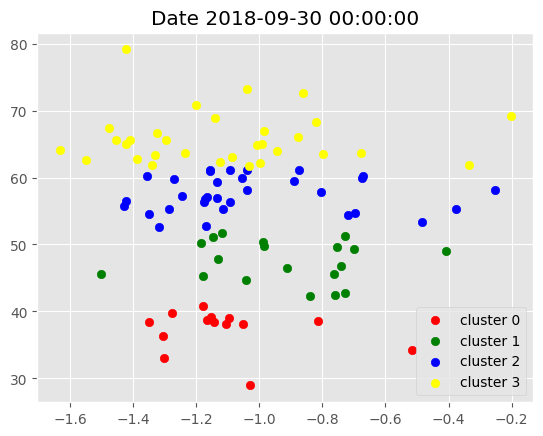

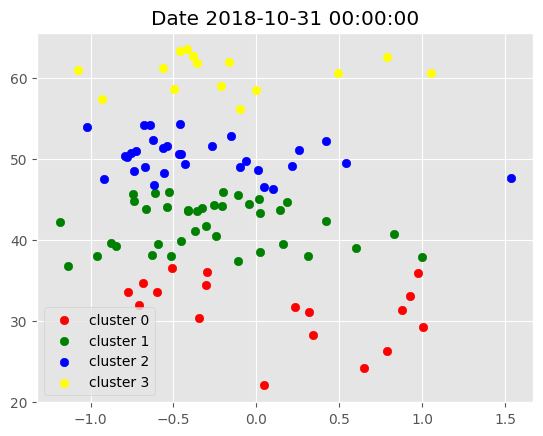

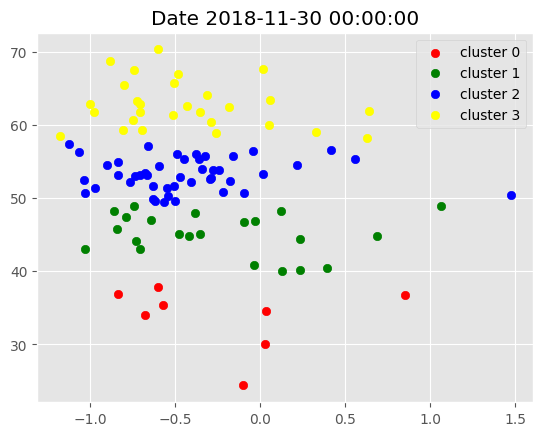

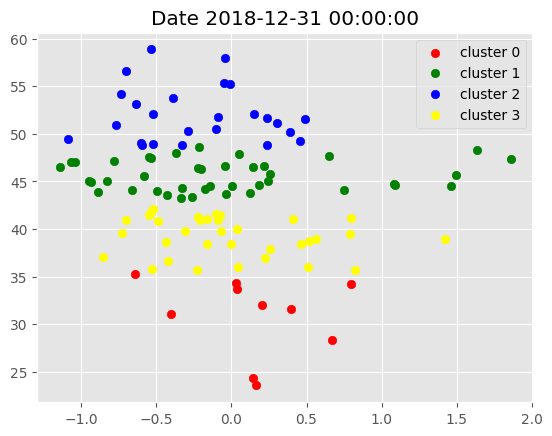

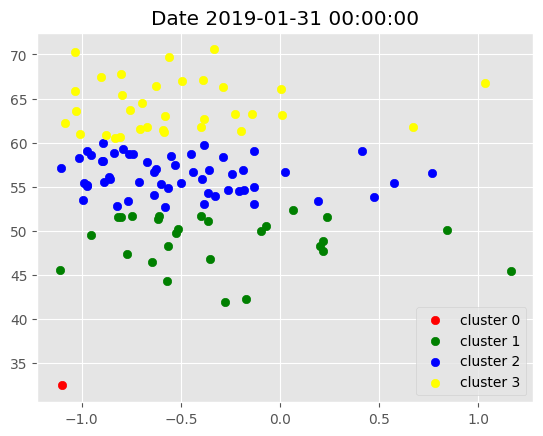

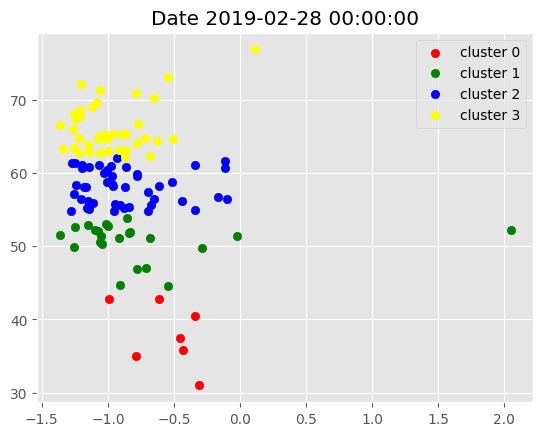

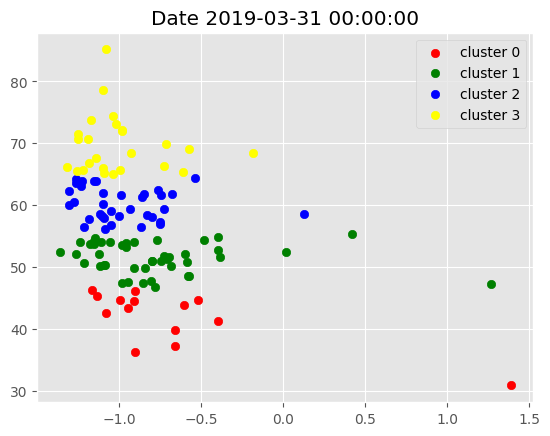

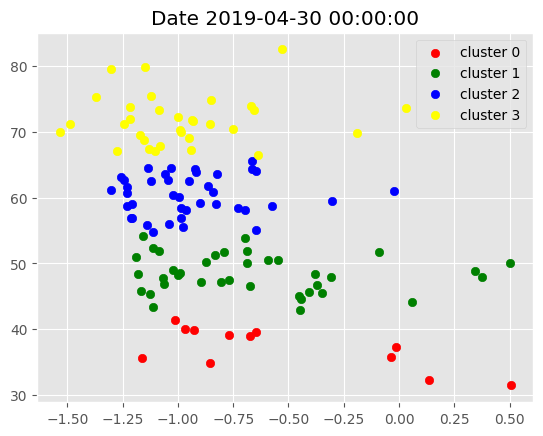

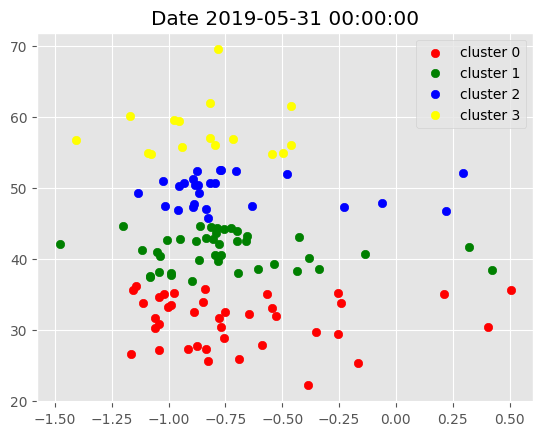

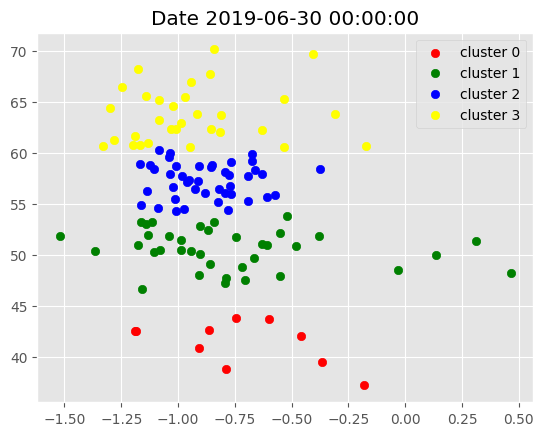

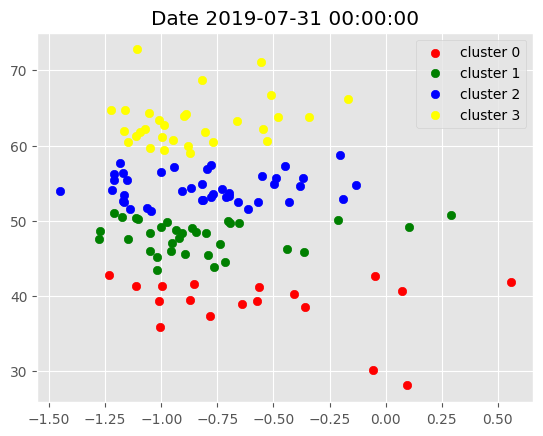

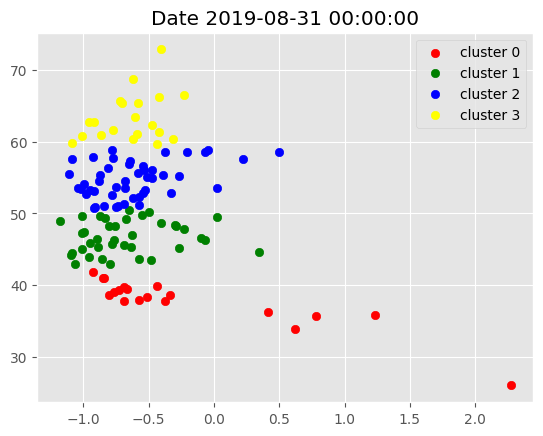

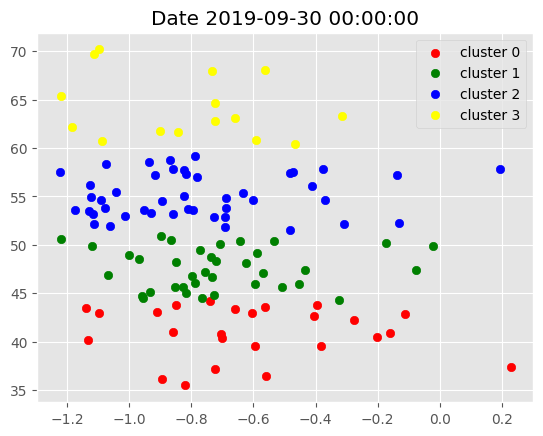

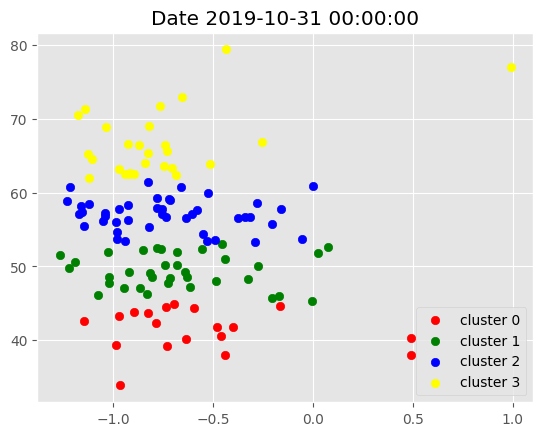

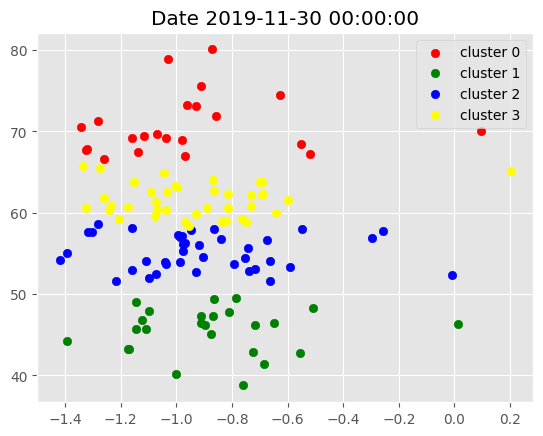

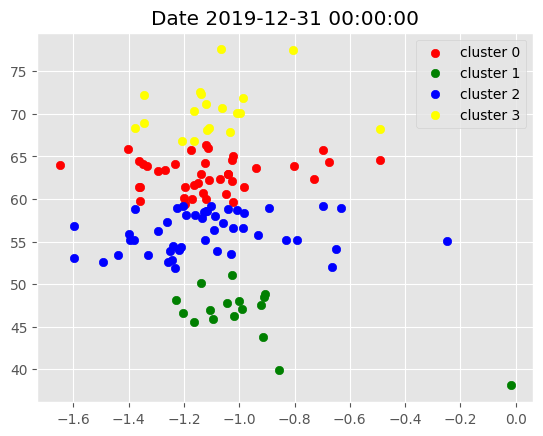

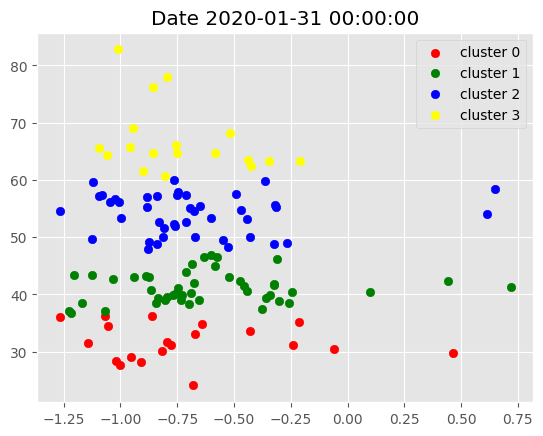

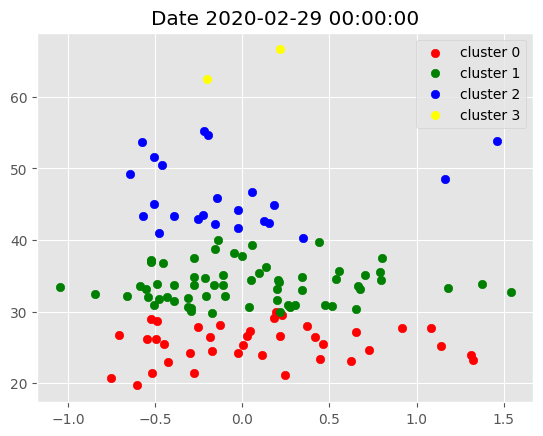

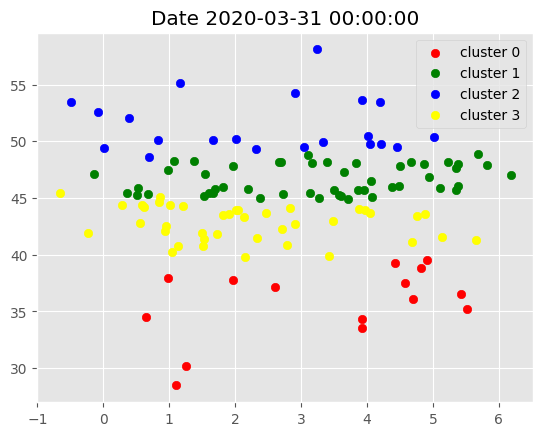

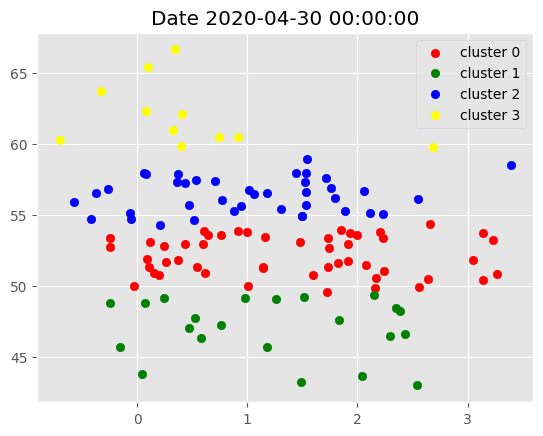

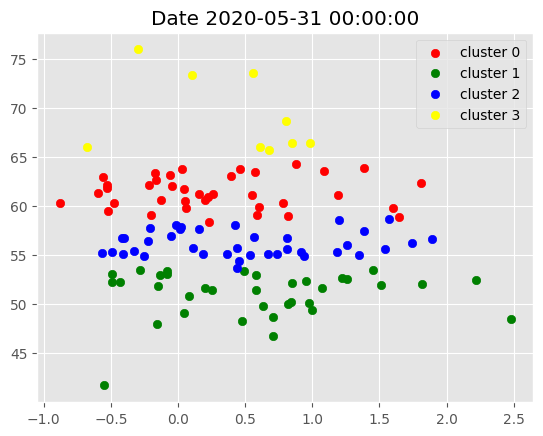

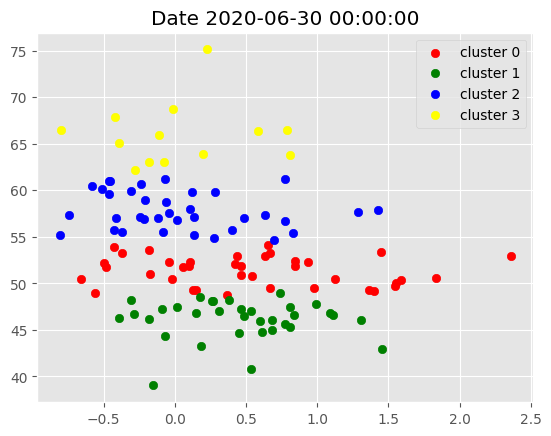

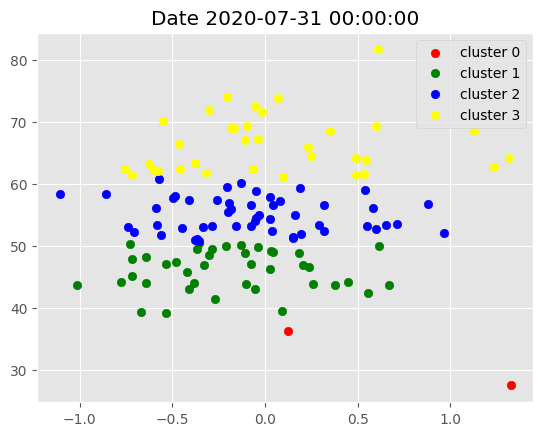

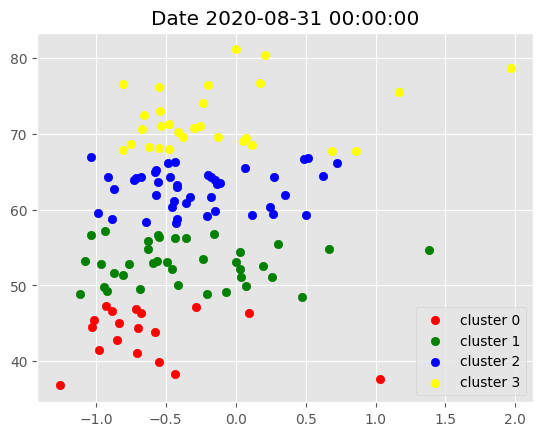

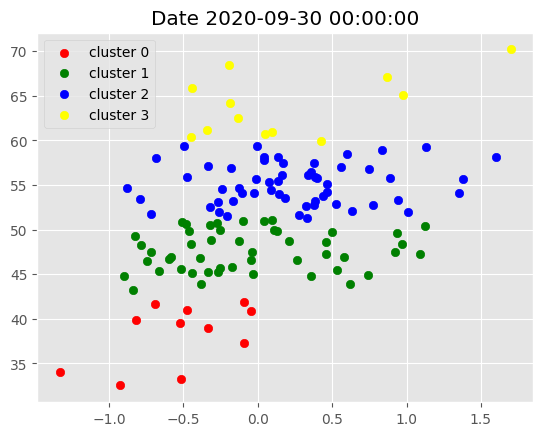

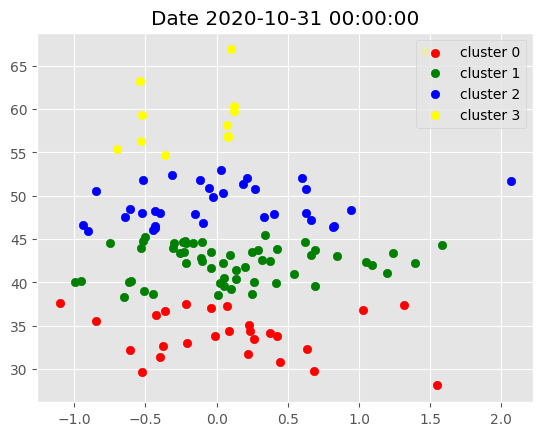

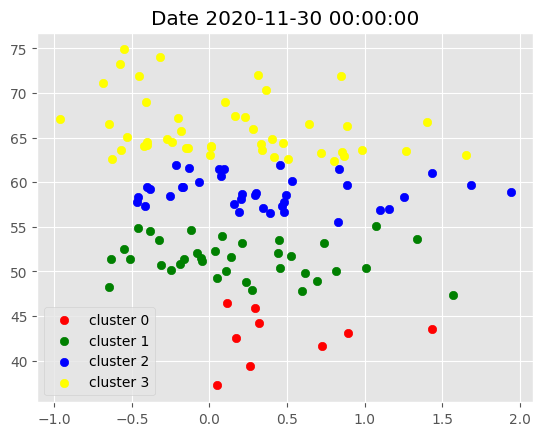

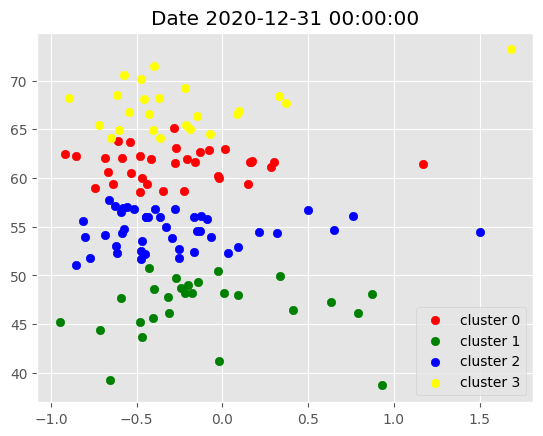

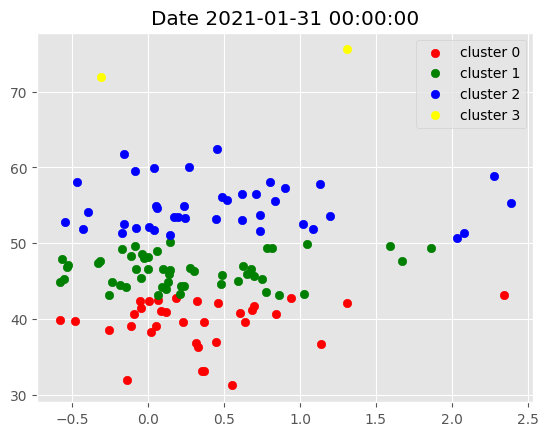

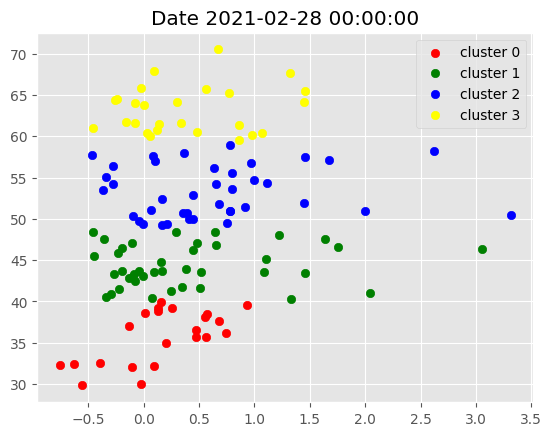

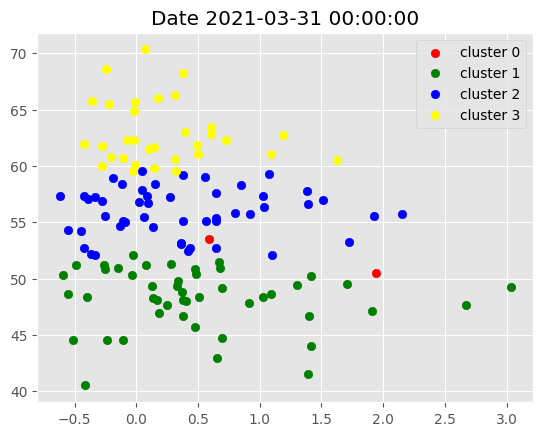

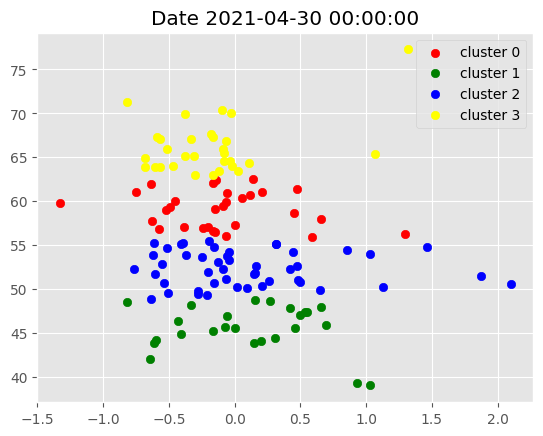

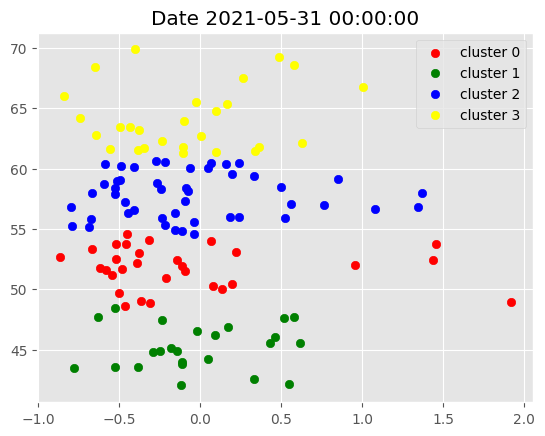

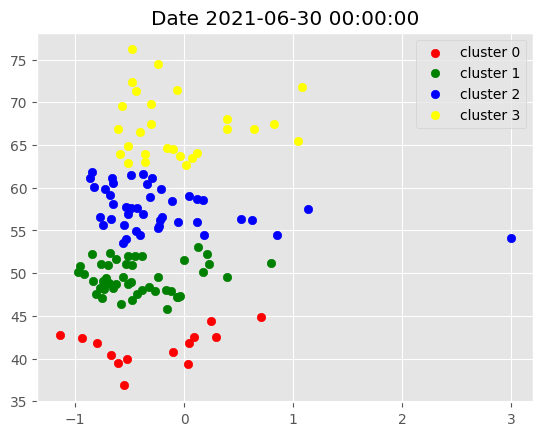

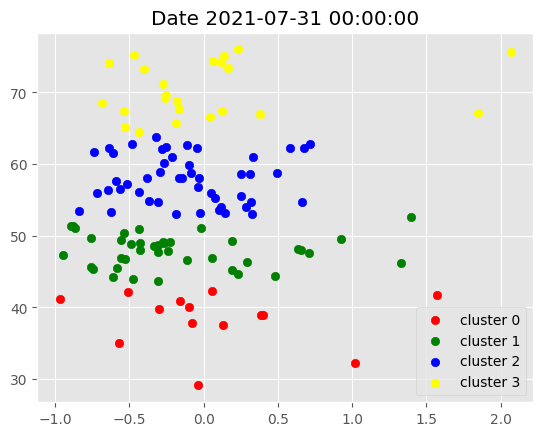

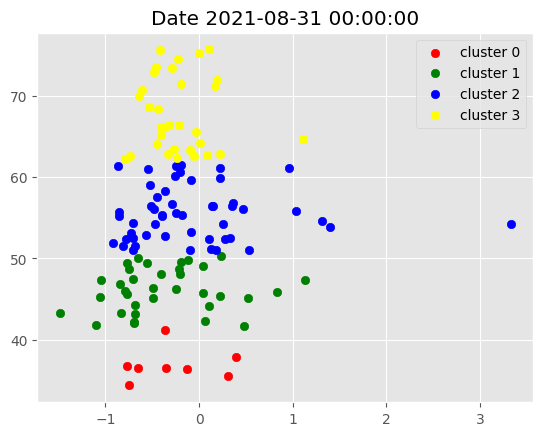

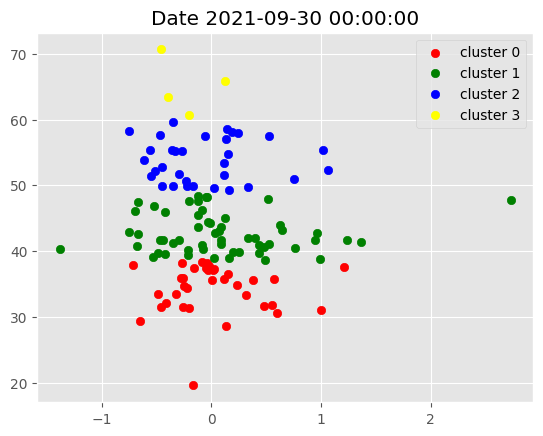

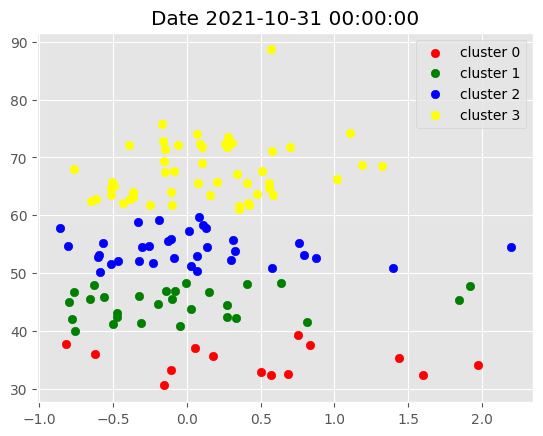

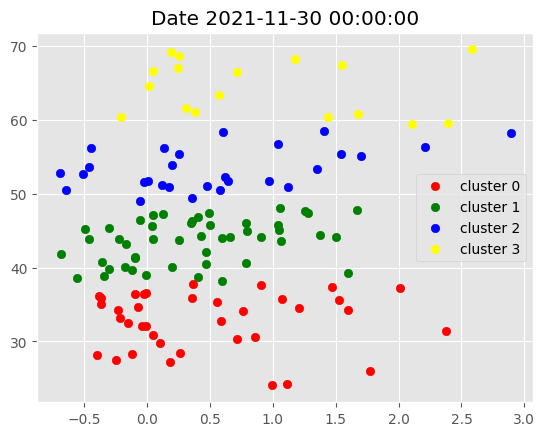

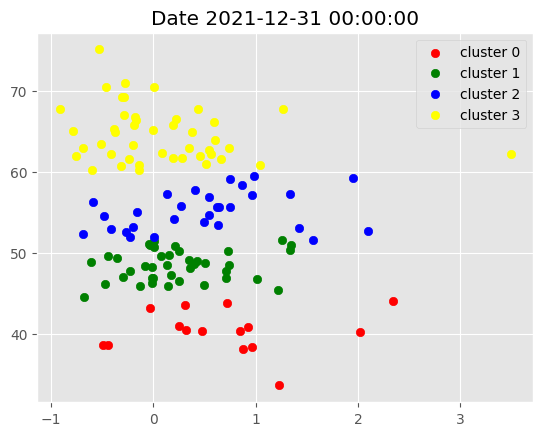

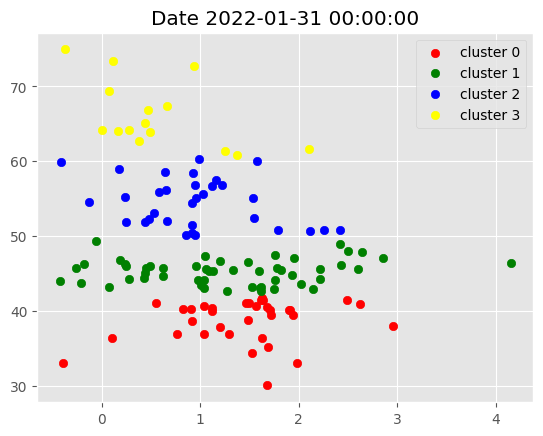

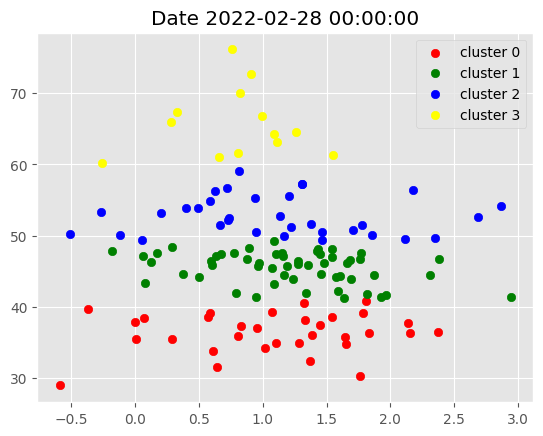

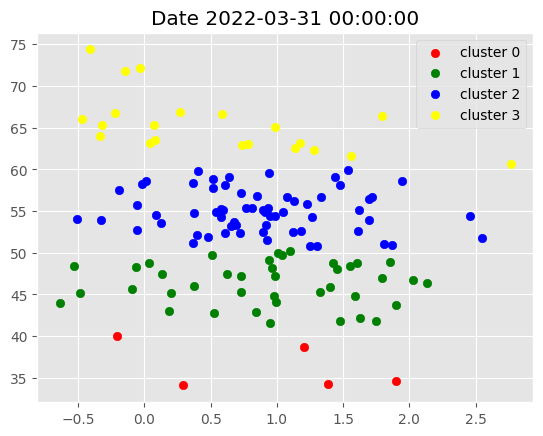

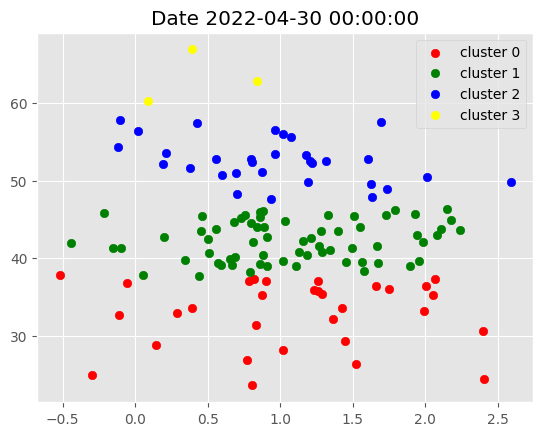

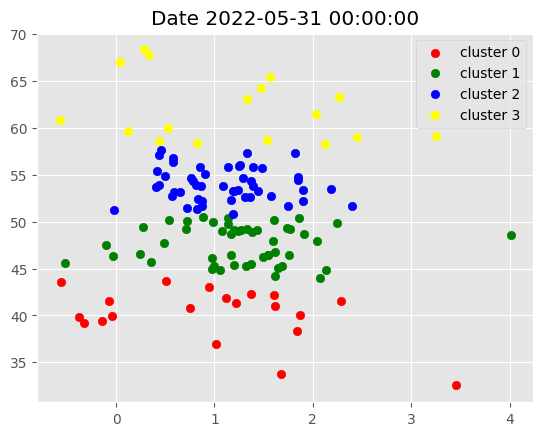

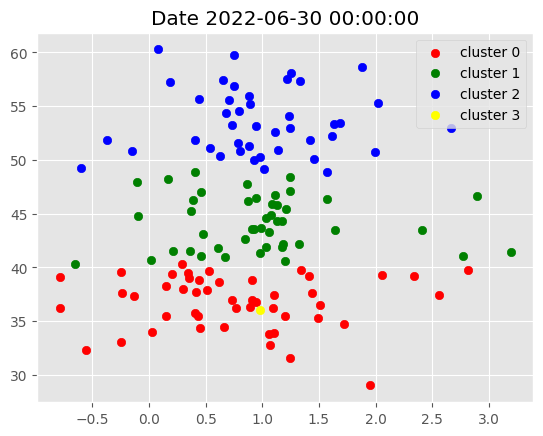

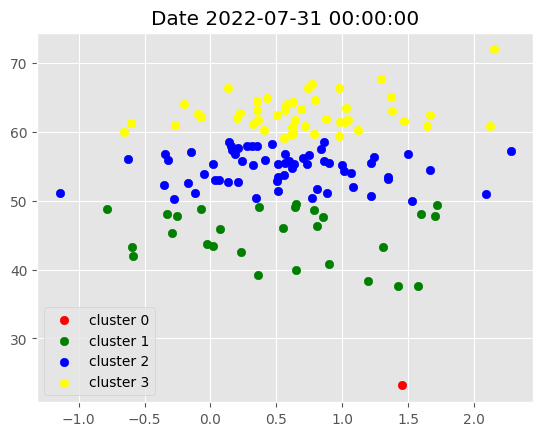

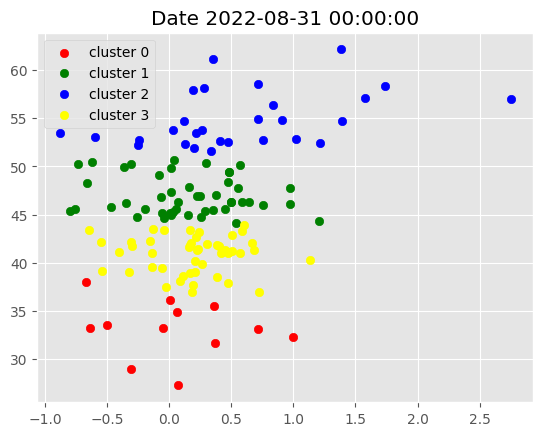

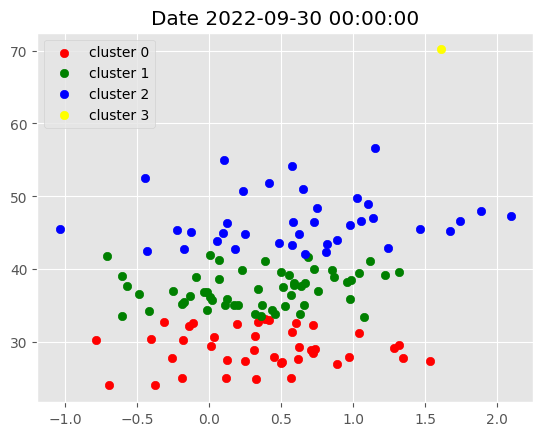

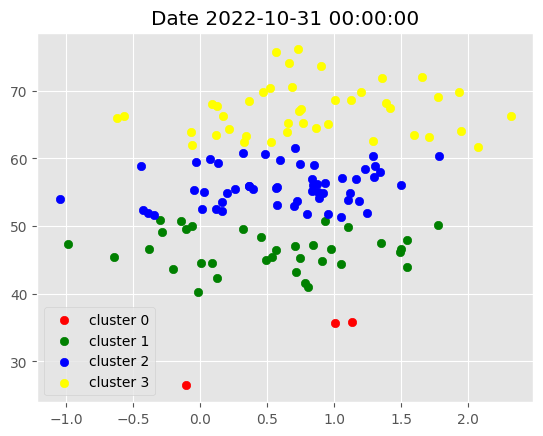

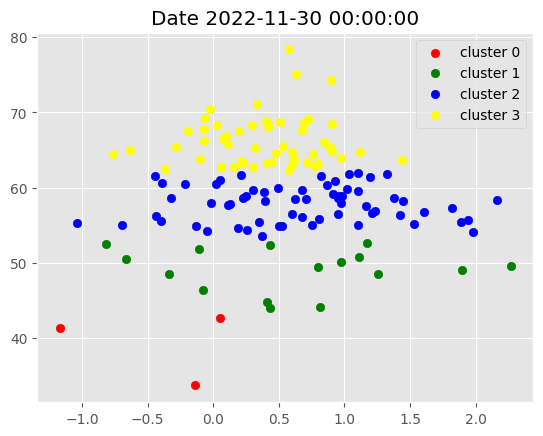

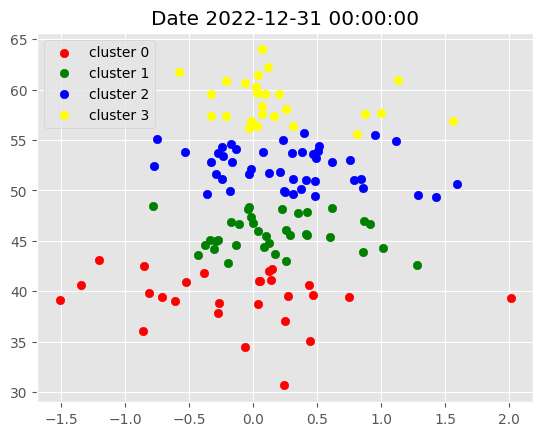

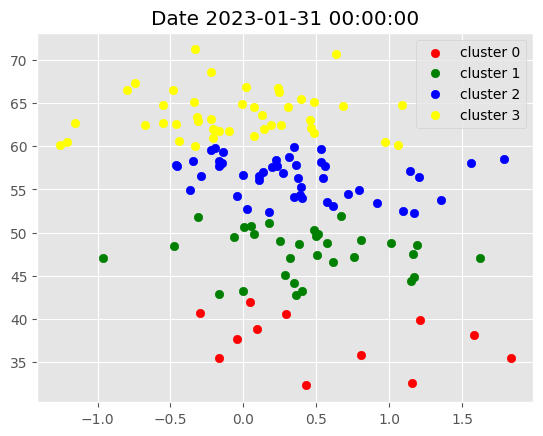

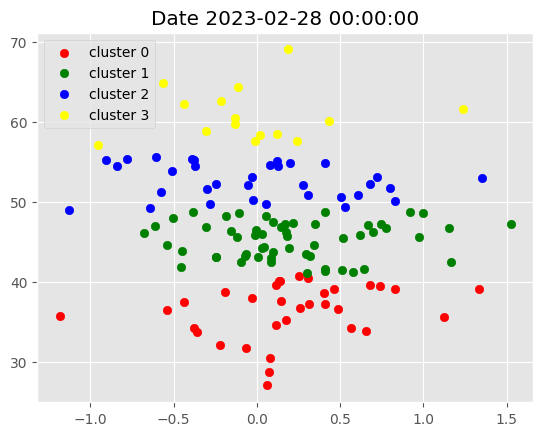

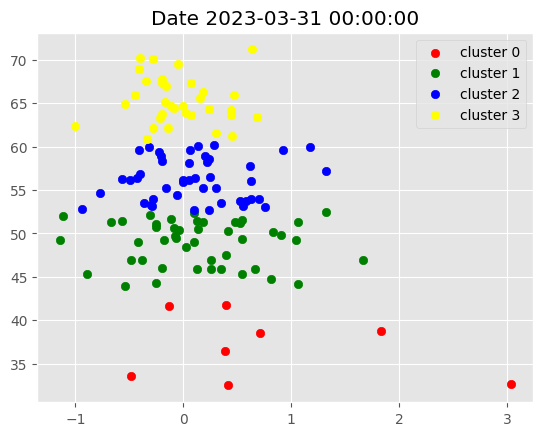

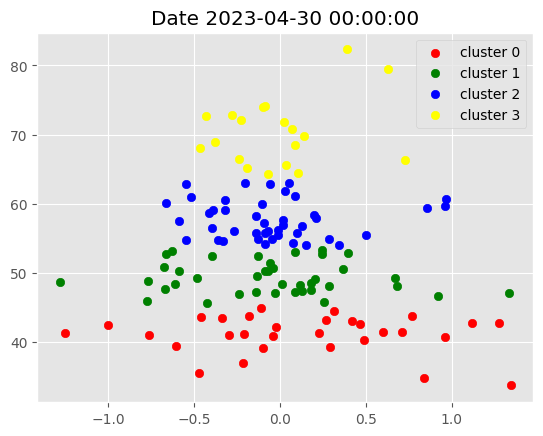

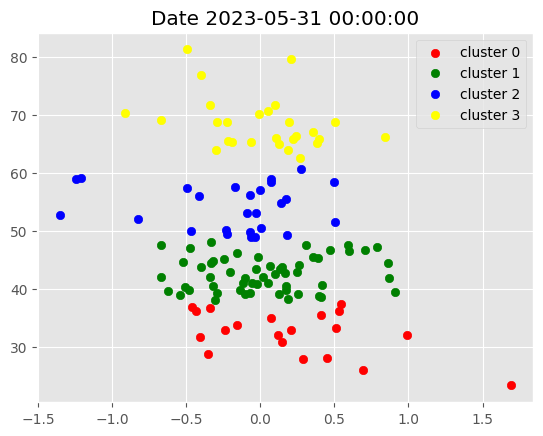

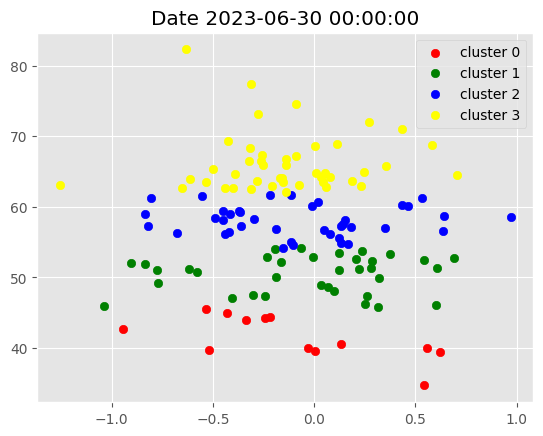

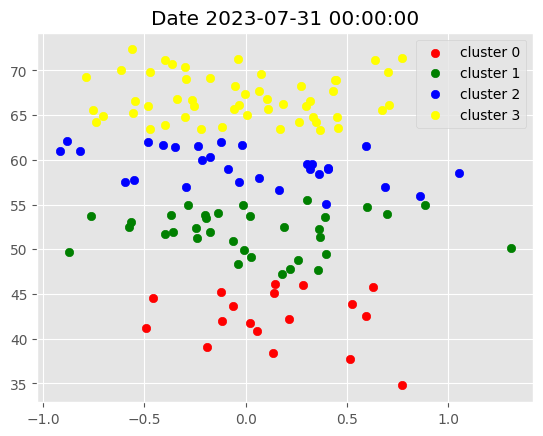

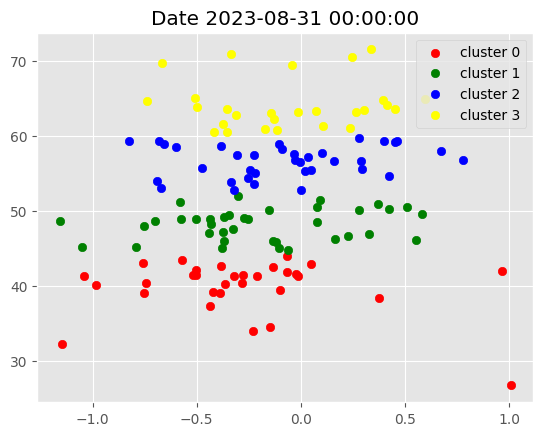

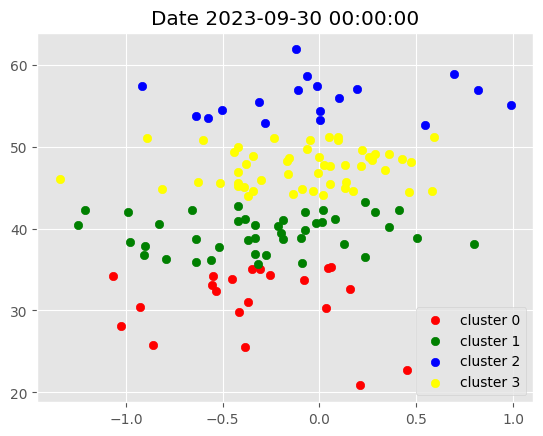

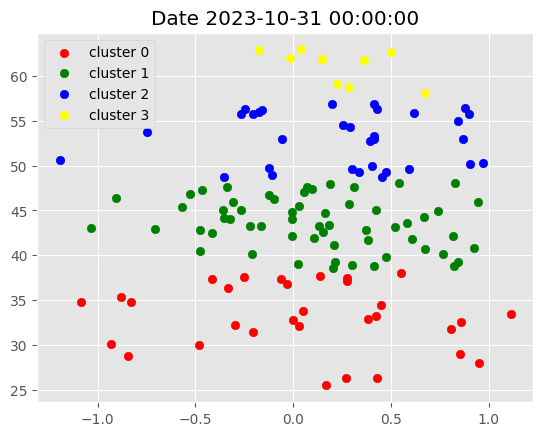

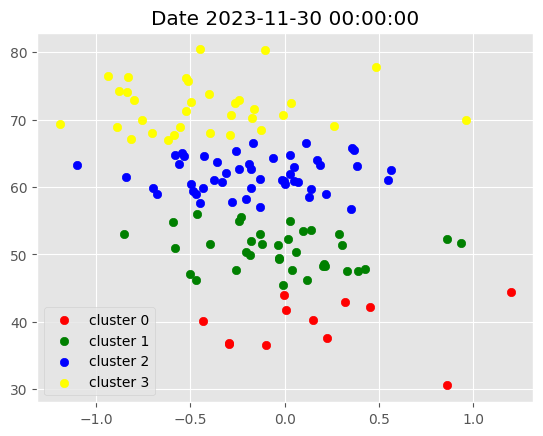

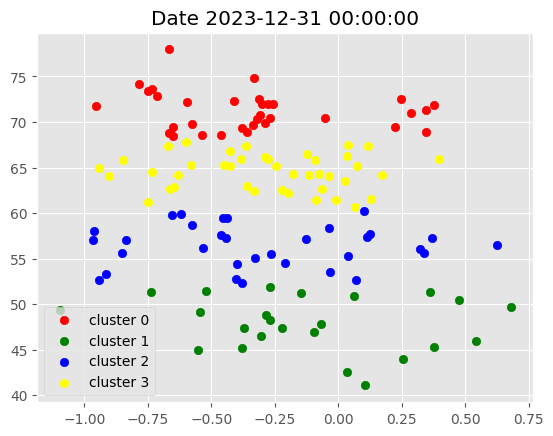

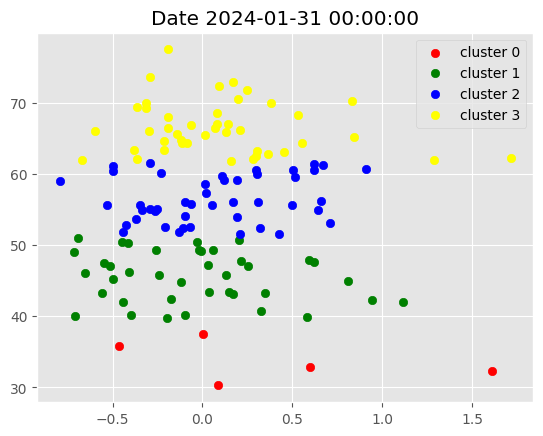

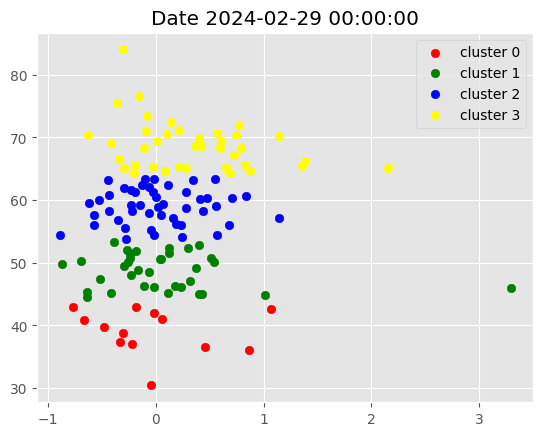

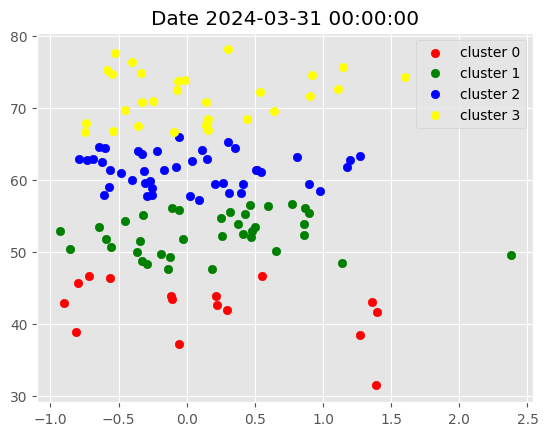

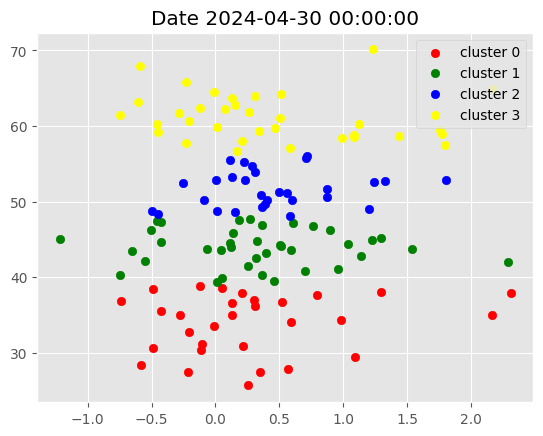

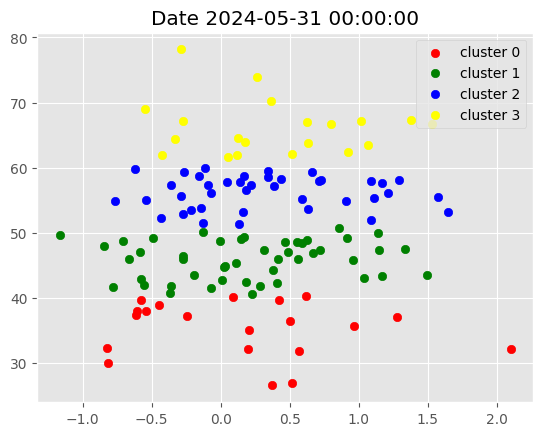

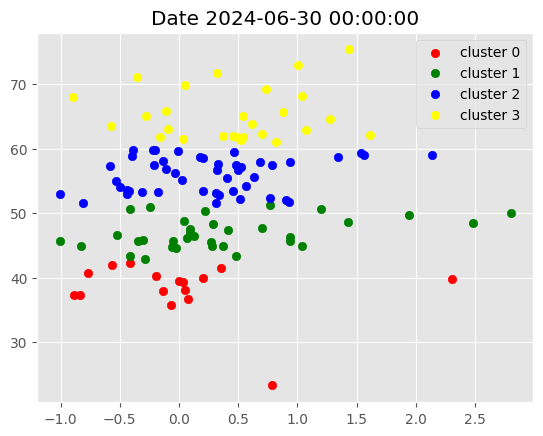

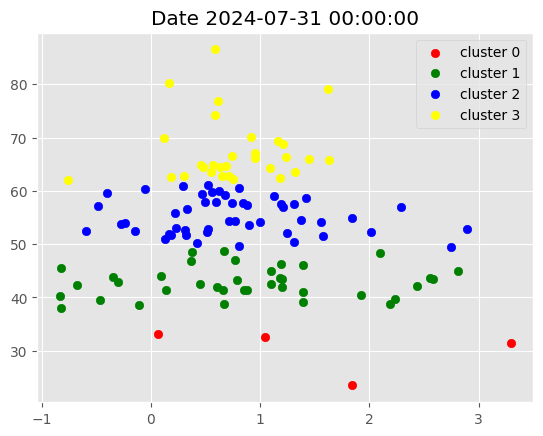

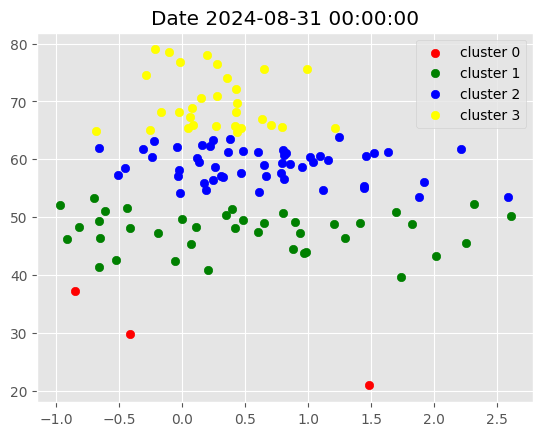

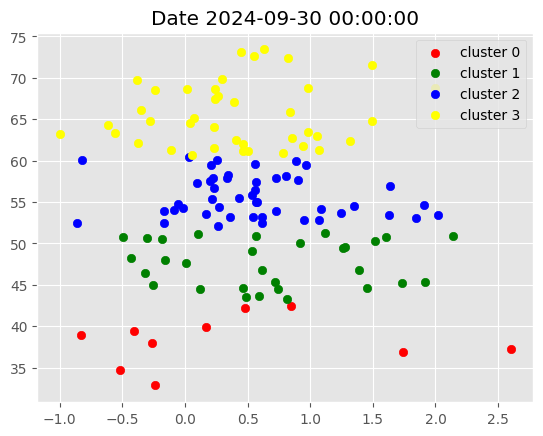

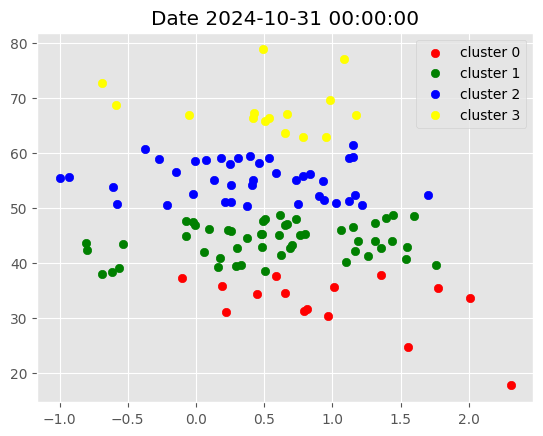

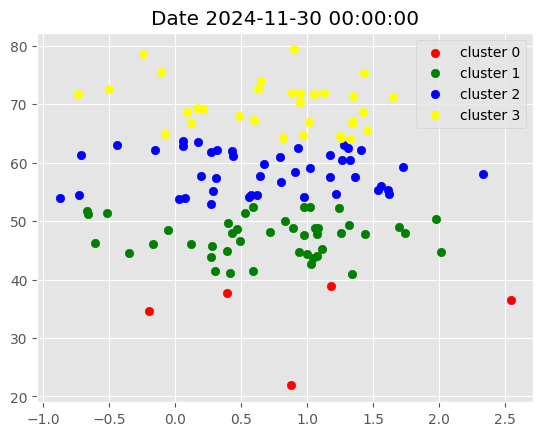

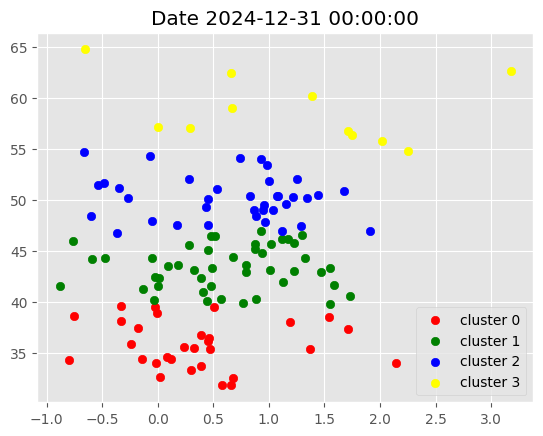

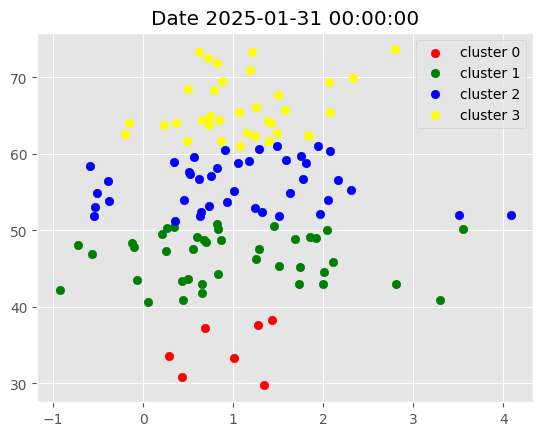

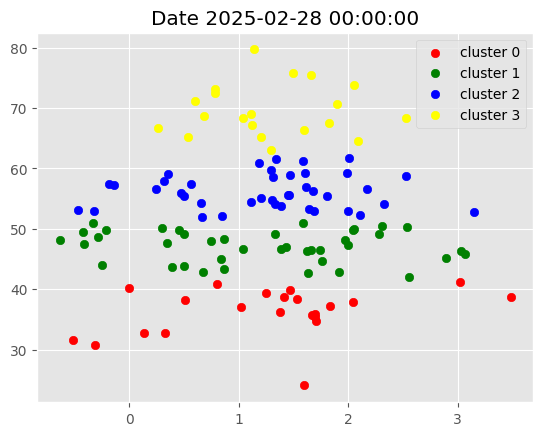

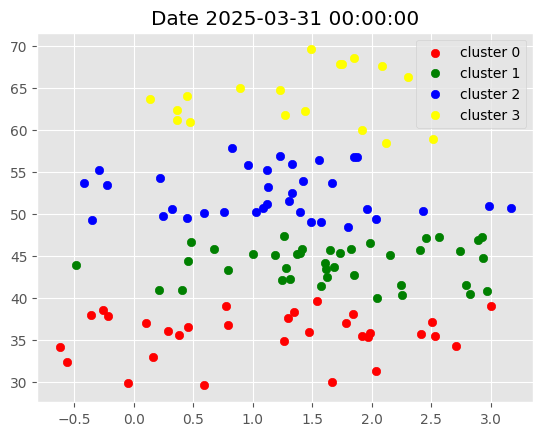

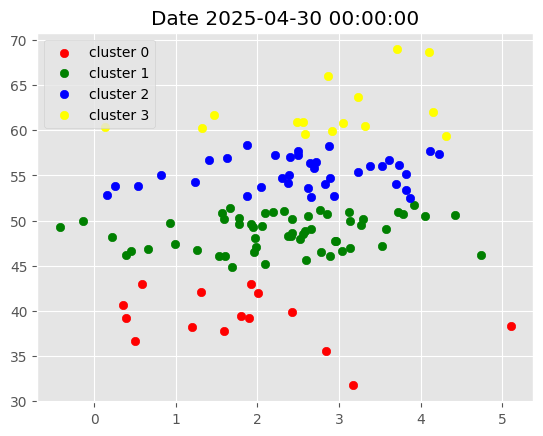

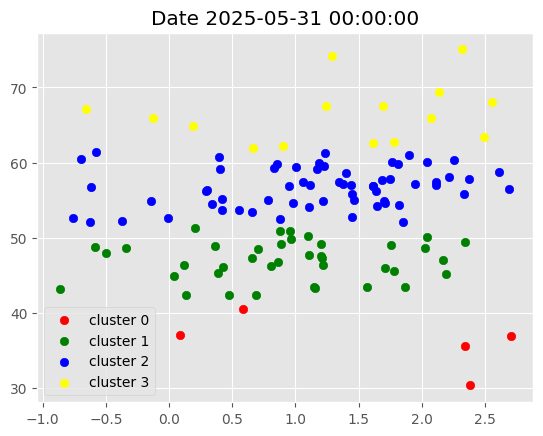

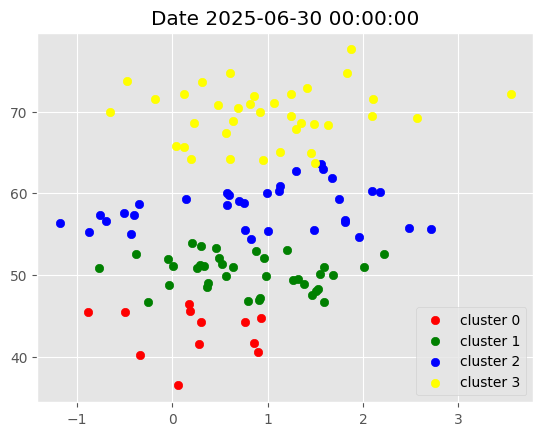

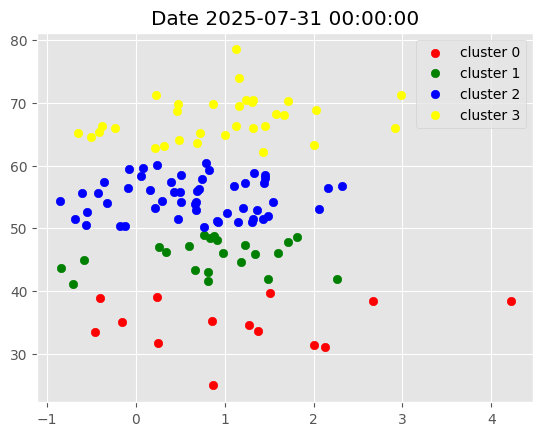

In [44]:
def plot_clusters(data):
  cluster_0 = data[data['cluster'] == 0]
  cluster_1 = data[data['cluster'] == 1]
  cluster_2 = data[data['cluster'] == 2]
  cluster_3 = data[data['cluster'] == 3]

# (X,Y) (atr, rsi)
  plt.scatter(cluster_0.iloc[:,5], cluster_0.iloc[:,1], color = 'red', label = 'cluster 0')
  plt.scatter(cluster_1.iloc[:,5], cluster_1.iloc[:,1], color = 'green', label = 'cluster 1')
  plt.scatter(cluster_2.iloc[:,5], cluster_2.iloc[:,1], color = 'blue', label = 'cluster 2')
  plt.scatter(cluster_3.iloc[:,5], cluster_3.iloc[:,1], color = 'yellow', label = 'cluster 3')

  plt.legend()
  plt.show()
  return

plt.style.use('ggplot')

for i in filtered_and_cluster.index.get_level_values('Date').unique().tolist():
  g = filtered_and_cluster.xs(i, level = 0)
  plt.title(f'Date {i}')
  plot_clusters(g)

In [45]:
cluster3 = filtered_and_cluster[filtered_and_cluster['cluster'] == 3].copy()
cluster3 = cluster3.reset_index(level = 1) #ticker becomes a column
cluster3.index = cluster3.index + pd.DateOffset(1) #move dates to beginning of next month
cluster3 = cluster3.reset_index().set_index(['Date', 'Ticker'])
today = pd.to_datetime("today").normalize()
cluster3 = cluster3[cluster3.index.get_level_values("Date") <= today]
cluster3

garman_klass_vol        rsi  bb_middle  bb_upper  bb_lower  \
Date       Ticker                                                               
2018-10-01 ABT             0.000037  79.127264   4.123610  4.192450  4.054769   
           AMD             0.003279  63.504080   3.449257  3.586184  3.312329   
           AMGN            0.000034  63.604121   5.108939  5.147011  5.070867   
           AVGO            0.000072  63.607944   3.013348  3.103825  2.922870   
           BA              0.000203  61.823767   5.849163  5.904577  5.793750   
...                             ...        ...        ...       ...       ...   
2025-07-01 NVDA            0.000145  72.141080   4.987586  5.064369  4.910802   
           ORCL            0.000488  72.221807   5.272416  5.471556  5.073275   
           SCHW            0.000047  65.811014   4.496986  4.518727  4.475244   
           TXN             0.000041  67.355157   5.294989  5.360237  5.229742   
           WFC             0.000101  65.025366   4.343205  4.402291  4.284120   

                   atr_zscore  macd_zscore  return_1m  return_2m  return_3m  \
Date       Ticker                                                             
2018-10-01 ABT      -1.423696     1.037545   0.097546   0.057978   0.065081   
           AMD      -0.798062     0.577465   0.227255   0.298158   0.250868   
           AMGN     -1.235417     0.520742   0.037436   0.030447   0.041771   
           AVGO     -0.676118    -0.075770   0.134924   0.058727   0.008098   
           BA       -0.336370     0.763731   0.084921   0.024178   0.036622   
...                       ...          ...        ...        ...        ...   
2025-07-01 NVDA      1.251059     3.162497   0.169252   0.204415   0.133888   
           ORCL      3.549812     5.275755   0.304119   0.239004   0.162099   
           SCHW      0.037533     0.679075   0.032828   0.060416   0.053519   
           TXN       0.568808     2.618212   0.135466   0.120299   0.052293   
           WFC       1.126501     1.403310   0.071410   0.065121   0.039165   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
Date       Ticker                                                         
2018-10-01 ABT      0.035906   0.029900    0.028503  0.806864 -0.139918   
           AMD      0.175305   0.117310    0.076529  1.806169 -0.935521   
           AMGN     0.035615   0.022203    0.011294  0.723827 -0.101975   
           AVGO     0.011187  -0.000560    0.004936  0.966504  0.361061   
           BA       0.022905   0.027800    0.033952  1.154826  1.385396   
...                      ...        ...         ...       ...       ...   
2025-07-01 NVDA     0.027486   0.029692    0.020736  2.485439 -0.709845   
           ORCL     0.047351   0.029027    0.038066  2.130559 -0.805460   
           SCHW     0.036624   0.039883    0.019144  1.165596 -0.323129   
           TXN      0.019817   0.003060    0.007867  1.240462  0.229330   
           WFC      0.023950   0.041459    0.027295  0.883415 -0.057805   

                        HML       RMW       CMA  cluster  
Date       Ticker                                         
2018-10-01 ABT    -0.342567  0.038760  0.989324        3  
           AMD    -0.575099 -0.693236 -0.172691        3  
           AMGN    0.049989  0.618813  0.829061        3  
           AVGO   -0.683612  0.129615  0.305432        3  
           BA     -0.138752  0.492687  0.415083        3  
...                     ...       ...       ...      ...  
2025-07-01 NVDA   -1.089248  1.259739  1.576744        3  
           ORCL   -0.699065  0.833275  0.686668        3  
           SCHW    0.611990 -1.957049  0.200616        3  
           TXN     0.130350  0.755819  1.739084        3  
           WFC     0.438256 -1.668170  0.068116        3  

[2172 rows x 19 columns]

In [46]:
cluster3

garman_klass_vol        rsi  bb_middle  bb_upper  bb_lower  \
Date       Ticker                                                               
2018-10-01 ABT             0.000037  79.127264   4.123610  4.192450  4.054769   
           AMD             0.003279  63.504080   3.449257  3.586184  3.312329   
           AMGN            0.000034  63.604121   5.108939  5.147011  5.070867   
           AVGO            0.000072  63.607944   3.013348  3.103825  2.922870   
           BA              0.000203  61.823767   5.849163  5.904577  5.793750   
...                             ...        ...        ...       ...       ...   
2025-07-01 NVDA            0.000145  72.141080   4.987586  5.064369  4.910802   
           ORCL            0.000488  72.221807   5.272416  5.471556  5.073275   
           SCHW            0.000047  65.811014   4.496986  4.518727  4.475244   
           TXN             0.000041  67.355157   5.294989  5.360237  5.229742   
           WFC             0.000101  65.025366   4.343205  4.402291  4.284120   

                   atr_zscore  macd_zscore  return_1m  return_2m  return_3m  \
Date       Ticker                                                             
2018-10-01 ABT      -1.423696     1.037545   0.097546   0.057978   0.065081   
           AMD      -0.798062     0.577465   0.227255   0.298158   0.250868   
           AMGN     -1.235417     0.520742   0.037436   0.030447   0.041771   
           AVGO     -0.676118    -0.075770   0.134924   0.058727   0.008098   
           BA       -0.336370     0.763731   0.084921   0.024178   0.036622   
...                       ...          ...        ...        ...        ...   
2025-07-01 NVDA      1.251059     3.162497   0.169252   0.204415   0.133888   
           ORCL      3.549812     5.275755   0.304119   0.239004   0.162099   
           SCHW      0.037533     0.679075   0.032828   0.060416   0.053519   
           TXN       0.568808     2.618212   0.135466   0.120299   0.052293   
           WFC       1.126501     1.403310   0.071410   0.065121   0.039165   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
Date       Ticker                                                         
2018-10-01 ABT      0.035906   0.029900    0.028503  0.806864 -0.139918   
           AMD      0.175305   0.117310    0.076529  1.806169 -0.935521   
           AMGN     0.035615   0.022203    0.011294  0.723827 -0.101975   
           AVGO     0.011187  -0.000560    0.004936  0.966504  0.361061   
           BA       0.022905   0.027800    0.033952  1.154826  1.385396   
...                      ...        ...         ...       ...       ...   
2025-07-01 NVDA     0.027486   0.029692    0.020736  2.485439 -0.709845   
           ORCL     0.047351   0.029027    0.038066  2.130559 -0.805460   
           SCHW     0.036624   0.039883    0.019144  1.165596 -0.323129   
           TXN      0.019817   0.003060    0.007867  1.240462  0.229330   
           WFC      0.023950   0.041459    0.027295  0.883415 -0.057805   

                        HML       RMW       CMA  cluster  
Date       Ticker                                         
2018-10-01 ABT    -0.342567  0.038760  0.989324        3  
           AMD    -0.575099 -0.693236 -0.172691        3  
           AMGN    0.049989  0.618813  0.829061        3  
           AVGO   -0.683612  0.129615  0.305432        3  
           BA     -0.138752  0.492687  0.415083        3  
...                     ...       ...       ...      ...  
2025-07-01 NVDA   -1.089248  1.259739  1.576744        3  
           ORCL   -0.699065  0.833275  0.686668        3  
           SCHW    0.611990 -1.957049  0.200616        3  
           TXN     0.130350  0.755819  1.739084        3  
           WFC     0.438256 -1.668170  0.068116        3  

[2172 rows x 19 columns]

In [47]:
dates = cluster3.index.get_level_values('Date').unique().tolist()

#create a dictionary including date and tickers that will be used for each month (the start of each month)
fixed_dates = {}
for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = cluster3.xs(d, level=0).index.tolist()


#dates are strings - contains list of tickers for the first date of each month
fixed_dates

{'2018-10-01': ['ABT',
  'AMD',
  'AMGN',
  'AVGO',
  'BA',
  'CAT',
  'CI',
  'COP',
  'CRM',
  'CSCO',
  'CVS',
  'DIS',
  'ELV',
  'HON',
  'ISRG',
  'LMT',
  'LOW',
  'MA',
  'MDT',
  'MRK',
  'MSFT',
  'ORCL',
  'PFE',
  'RTX',
  'SBUX',
  'TGT',
  'TJX',
  'TMO',
  'UNP',
  'V',
  'XYZ'],
 '2018-11-01': ['CI',
  'CMCSA',
  'F',
  'GM',
  'JNJ',
  'KO',
  'MCD',
  'MO',
  'MRK',
  'PG',
  'PM',
  'SBUX',
  'TSLA',
  'VZ',
  'WMT'],
 '2018-12-01': ['ABBV',
  'ABT',
  'AMGN',
  'AMT',
  'AXP',
  'CI',
  'CMCSA',
  'CVS',
  'DAL',
  'DE',
  'ELV',
  'GM',
  'JNJ',
  'KO',
  'LLY',
  'LRCX',
  'MCD',
  'MDLZ',
  'MDT',
  'MMM',
  'MRK',
  'PEP',
  'PFE',
  'PG',
  'SBUX',
  'TMO',
  'UNH',
  'VZ'],
 '2019-01-01': ['AAPL',
  'ACN',
  'AXP',
  'BAC',
  'CHTR',
  'CI',
  'CMCSA',
  'COST',
  'CSX',
  'DAL',
  'EA',
  'EOG',
  'GILD',
  'GS',
  'HON',
  'IBM',
  'JNJ',
  'JPM',
  'LMT',
  'MDLZ',
  'META',
  'MO',
  'MS',
  'MU',
  'NOC',
  'OXY',
  'T',
  'TGT',
  'TJX',
  'ULTA',
  'UPS

#Portfolio optimization

In [48]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

#requires prices for the past year
def optimize_weights(prices, lower_bound=0):

    #expected average return per year (252 trading days)
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)


    #create a covariance matrix - movement of stocks in respect to others
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)

    #EF = risk-return relationship for all portfolio options
    #sets up the optimization problem
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')

    #extract the optimal portfolio. store optimal weights in ef.
    weights = ef.max_sharpe()

    #output is a dictionary of ticker:weight
    return ef.clean_weights()

In [49]:
#download price data again from Yfinance

#get all stock tickers found in cluster 3
all_stocks_3 = pd.Series([ticker for sublist in fixed_dates.values() for ticker in sublist]).unique().tolist()

all_stocks_3_sorted = sorted(all_stocks_3)

# Convert the keys (date strings) to datetime
all_dates = pd.to_datetime(list(fixed_dates.keys()))

# Find the date range
start_date = all_dates.min() - timedelta(days=365)
end_date = all_dates.max() #will be the first day of the current month

data = yf.download(
    tickers=all_stocks_3_sorted,
    start=start_date.strftime('%Y-%m-%d'),
    end=end_date.strftime('%Y-%m-%d'),
    auto_adjust=True,
    progress=False
)
data

Price            Close                                                  \
Ticker            AAPL        ABBV        ABNB         ABT         ACN   
Date                                                                     
2017-10-02   35.967590   64.219788         NaN   46.619862  119.798569   
2017-10-03   36.124252   63.729568         NaN   46.680656  118.745979   
2017-10-04   35.890419   63.871662         NaN   47.193058  119.550911   
2017-10-05   36.337070   64.070595         NaN   47.696766  120.488503   
2017-10-06   36.316021   64.290848         NaN   47.766247  120.515038   
...                ...         ...         ...         ...         ...   
2025-06-24  200.300003  183.961121  132.149994  137.462967  300.720001   
2025-06-25  201.559998  183.802490  129.669998  136.785995  294.600006   
2025-06-26  201.000000  185.190491  133.720001  133.072662  296.079987   
2025-06-27  201.080002  180.748856  134.520004  133.779510  295.459991   
2025-06-30  205.169998  184.030518  132.339996  135.402206  298.890015   

Price                                                                   ...  \
Ticker            ADBE         ADI         ADP        ADSK        ALGN  ...   
Date                                                                    ...   
2017-10-02  147.940002   74.162971   92.882393  112.470001  187.220001  ...   
2017-10-03  148.600006   74.232101   94.063370  113.629997  186.449997  ...   
2017-10-04  147.949997   75.182686   94.649605  114.050003  185.979996  ...   
2017-10-05  150.250000   75.951790   96.493347  116.540001  186.610001  ...   
2017-10-06  151.119995   75.934509   96.416862  116.959999  187.039993  ...   
...                ...         ...         ...         ...         ...  ...   
2025-06-24  382.339996  234.979996  311.399994  304.190002  186.580002  ...   
2025-06-25  387.549988  234.679993  298.190002  302.369995  187.139999  ...   
2025-06-26  384.950012  237.300003  302.980011  304.929993  187.740005  ...   
2025-06-27  385.829987  236.960007  303.450012  305.130005  188.520004  ...   
2025-06-30  386.880005  238.020004  308.399994  309.570007  189.330002  ...   

Price        Volume                                                           \
Ticker          VLO     VRTX        VZ     WDAY      WDC       WFC       WMT   
Date                                                                           
2017-10-02  3141300  2057700   9525800  1631400  9925543  11764400  23127600   
2017-10-03  3194700   995000  10218600  1096200  6054710  17405100  23810100   
2017-10-04  2669900   970200   9887500   861600  4517119  14697800  18520200   
2017-10-05  4923400  1273700  12230600  1492300  7251892  14560700  15416100   
2017-10-06  4672400  1551100  13239600  2246600  4617138  11151200  18740100   
...             ...      ...       ...      ...      ...       ...       ...   
2025-06-24  2973200  1068000  16716300  2478100  6021000  16342300  22403700   
2025-06-25  2327800  1077100  15599700  1958800  4530300  13954500  11154700   
2025-06-26  2743700  1169200  15870000  2076500  5930300  18214800  19361400   
2025-06-27  8049500  3615500  21439600  1812200  6642300  21324200  31431900   
2025-06-30  2413500  1114600  22796000  1516800  6074400  21685800  17803000   

Price                                   
Ticker         WYNN       XOM      XYZ  
Date                                    
2017-10-02  3006000   6777900  6336000  
2017-10-03  1709000   6082000  8843300  
2017-10-04  1525000   6357100  7434100  
2017-10-05  1718500   7375900  7507300  
2017-10-06  3339400   6070600  4008100  
...             ...       ...      ...  
2025-06-24  1765700  24828300  6303200  
2025-06-25  1774300  17483200  5395900  
2025-06-26  1605800  18304800  5097200  
2025-06-27  2640900  22002100  9854300  
2025-06-30  1730800  19199000  5628600  

[1946 rows x 770 columns]

In [50]:
data

Price            Close                                                  \
Ticker            AAPL        ABBV        ABNB         ABT         ACN   
Date                                                                     
2017-10-02   35.967590   64.219788         NaN   46.619862  119.798569   
2017-10-03   36.124252   63.729568         NaN   46.680656  118.745979   
2017-10-04   35.890419   63.871662         NaN   47.193058  119.550911   
2017-10-05   36.337070   64.070595         NaN   47.696766  120.488503   
2017-10-06   36.316021   64.290848         NaN   47.766247  120.515038   
...                ...         ...         ...         ...         ...   
2025-06-24  200.300003  183.961121  132.149994  137.462967  300.720001   
2025-06-25  201.559998  183.802490  129.669998  136.785995  294.600006   
2025-06-26  201.000000  185.190491  133.720001  133.072662  296.079987   
2025-06-27  201.080002  180.748856  134.520004  133.779510  295.459991   
2025-06-30  205.169998  184.030518  132.339996  135.402206  298.890015   

Price                                                                   ...  \
Ticker            ADBE         ADI         ADP        ADSK        ALGN  ...   
Date                                                                    ...   
2017-10-02  147.940002   74.162971   92.882393  112.470001  187.220001  ...   
2017-10-03  148.600006   74.232101   94.063370  113.629997  186.449997  ...   
2017-10-04  147.949997   75.182686   94.649605  114.050003  185.979996  ...   
2017-10-05  150.250000   75.951790   96.493347  116.540001  186.610001  ...   
2017-10-06  151.119995   75.934509   96.416862  116.959999  187.039993  ...   
...                ...         ...         ...         ...         ...  ...   
2025-06-24  382.339996  234.979996  311.399994  304.190002  186.580002  ...   
2025-06-25  387.549988  234.679993  298.190002  302.369995  187.139999  ...   
2025-06-26  384.950012  237.300003  302.980011  304.929993  187.740005  ...   
2025-06-27  385.829987  236.960007  303.450012  305.130005  188.520004  ...   
2025-06-30  386.880005  238.020004  308.399994  309.570007  189.330002  ...   

Price        Volume                                                           \
Ticker          VLO     VRTX        VZ     WDAY      WDC       WFC       WMT   
Date                                                                           
2017-10-02  3141300  2057700   9525800  1631400  9925543  11764400  23127600   
2017-10-03  3194700   995000  10218600  1096200  6054710  17405100  23810100   
2017-10-04  2669900   970200   9887500   861600  4517119  14697800  18520200   
2017-10-05  4923400  1273700  12230600  1492300  7251892  14560700  15416100   
2017-10-06  4672400  1551100  13239600  2246600  4617138  11151200  18740100   
...             ...      ...       ...      ...      ...       ...       ...   
2025-06-24  2973200  1068000  16716300  2478100  6021000  16342300  22403700   
2025-06-25  2327800  1077100  15599700  1958800  4530300  13954500  11154700   
2025-06-26  2743700  1169200  15870000  2076500  5930300  18214800  19361400   
2025-06-27  8049500  3615500  21439600  1812200  6642300  21324200  31431900   
2025-06-30  2413500  1114600  22796000  1516800  6074400  21685800  17803000   

Price                                   
Ticker         WYNN       XOM      XYZ  
Date                                    
2017-10-02  3006000   6777900  6336000  
2017-10-03  1709000   6082000  8843300  
2017-10-04  1525000   6357100  7434100  
2017-10-05  1718500   7375900  7507300  
2017-10-06  3339400   6070600  4008100  
...             ...       ...      ...  
2025-06-24  1765700  24828300  6303200  
2025-06-25  1774300  17483200  5395900  
2025-06-26  1605800  18304800  5097200  
2025-06-27  2640900  22002100  9854300  
2025-06-30  1730800  19199000  5628600  

[1946 rows x 770 columns]

In [51]:
# Calculate log returns per ticker
returns = np.log(data['Close']).diff()

returns

Ticker,AAPL,ABBV,ABNB,ABT,ACN,ADBE,ADI,ADP,ADSK,ALGN,...,VLO,VRTX,VZ,WDAY,WDC,WFC,WMT,WYNN,XOM,XYZ
Date,,,,,,,,,,,,,,,,,,,,,
2017-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-03,0.004346,-0.007663,NaN,0.001303,-0.008825,0.004451,0.000932,0.012635,0.010261,-0.004121,...,0.006726,0.001838,0.009878,0.011838,-0.004688,0.001981,0.009768,0.000136,0.001591,0.018541
2017-10-04,-0.006494,0.002227,NaN,0.010917,0.006756,-0.004384,0.012724,0.006213,0.003689,-0.002524,...,0.001546,0.000000,0.001003,0.007055,0.016134,-0.011218,-0.001643,-0.000816,0.000367,0.006990
2017-10-05,0.012368,0.003110,NaN,0.010617,0.007812,0.015426,0.010178,0.019292,0.021598,0.003382,...,-0.005421,-0.001378,-0.002609,0.016676,-0.009171,0.007793,0.004038,-0.000068,0.002808,0.020030
2017-10-06,-0.000579,0.003432,NaN,0.001456,0.000220,0.005774,-0.000228,-0.000793,0.003597,0.002302,...,-0.000517,0.018218,-0.007551,0.029460,0.003225,0.003425,-0.005176,-0.020764,-0.003787,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-24,-0.005973,0.009694,0.012335,0.035531,0.019204,0.005823,0.017169,0.003732,0.010708,0.017082,...,-0.008867,0.015059,0.006354,0.010972,0.027605,0.014183,0.001327,0.014059,-0.030900,0.026676
2025-06-25,0.006271,-0.000863,-0.018945,-0.004937,-0.020561,0.013535,-0.001278,-0.043347,-0.006001,0.002997,...,-0.000957,-0.009932,-0.012036,-0.024247,0.007703,0.012215,-0.007580,0.010280,0.000277,-0.008144
2025-06-26,-0.002782,0.007523,0.030755,-0.027522,0.005011,-0.006731,0.011102,0.015936,0.008431,0.003201,...,0.009168,-0.005443,-0.000475,0.015935,0.015231,0.011193,-0.012831,0.007911,0.014838,0.004618


In [52]:
pd.Timestamp('2018-10-01') in returns.index

True

In [53]:
# Convert the result into a DataFrame with MultiIndex (Date, Ticker)

returns_multiindex = returns.stack().to_frame(name='Log Return')
returns_multiindex.index.names = ['Date', 'Ticker']
returns_multiindex = returns_multiindex.sort_index()

In [54]:
returns_multiindex

Log Return
Date       Ticker            
2017-10-03 AAPL      0.004346
           ABBV     -0.007663
           ABT       0.001303
           ACN      -0.008825
           ADBE      0.004451
...                       ...
2025-06-30 WFC       0.007769
           WMT       0.005229
           WYNN     -0.010725
           XOM      -0.014550
           XYZ       0.019323

[294661 rows x 1 columns]

#Optimal portafolio

In [55]:
portafolio_df = pd.DataFrame()
data_multi = (
    data.stack(level=1)  # stack ticker level (e.g., 'AAPL', 'MSFT')
        .reset_index()   # convert index to columns
        .rename(columns={"level_1": "Ticker"})  # rename the stacked level
        .set_index(["Date", "Ticker"])  # set multi-index
        .sort_index()
)
data_multi

Price                   Close        High         Low        Open      Volume
Date       Ticker                                                            
2017-10-02 AAPL     35.967590   36.117251   35.712701   36.072820  74795200.0
           ABBV     64.219788   64.234000   63.168288   63.757978   6600100.0
           ABT      46.619862   46.637232   46.202993   46.585122   8681900.0
           ACN     119.798569  120.152369  119.073261  119.612815   2667500.0
           ADBE    147.940002  150.479996  147.520004  149.789993   2341700.0
...                       ...         ...         ...         ...         ...
2025-06-30 WFC      80.120003   81.099998   79.910004   80.480003  21685800.0
           WMT      97.779999   98.139999   96.309998   97.230003  17803000.0
           WYNN     93.669998   94.669998   92.750000   94.559998   1730800.0
           XOM     107.800003  108.839996  107.720001  108.639999  19199000.0
           XYZ      67.930000   68.400002   67.059998   67.139999   5628600.0

[294815 rows x 5 columns]

In [56]:
#WEIGHTS ARE MONTHLY, RETURNS ARE DAILY...

start_date = '2018-10-01'
start_date = pd.to_datetime(start_date)
end_date = start_date + pd.offsets.MonthEnd(0) #until the end of that month

#use closing prices from the previous year until the past day
optimization_start_date = start_date - pd.DateOffset(months=12)
optimization_end_date = start_date - pd.DateOffset(days=1)
cols = fixed_dates[str(start_date.date())] #only for the top performing stocks for this month
prices_optimization = (data.loc[optimization_start_date : optimization_end_date, ('Close',cols)].copy()).dropna()

# Set up returns
returns_temp = returns[start_date:end_date][cols].copy()
returns_stacked = returns_temp.stack().to_frame(name='Log Return')

#Set up weights
weights_dict = optimize_weights(prices = prices_optimization, lower_bound=round(1/(len(prices_optimization.columns)*2),3))
weights = pd.Series(weights_dict, name = 'Weight')

weights_repeated = pd.DataFrame(
    [weights.values] * len(returns_temp.index),  # each row = weights
    index=returns_temp.index,
    columns=weights.index
)

weights_stacked = weights_repeated.stack() # Stack into (Date, Ticker) format
weights_stacked.columns = ['Weight']

combined = pd.concat([returns_stacked, weights_stacked], axis=1)
combined.index.names = ['Date', 'Ticker']

#calculate weighted returns
combined['WeightedR'] = combined['Log Return']*combined['Weight']
print(combined)

#sum returns for each day
strategy_return = combined.groupby(level = 'Date')['WeightedR'].sum().to_frame('Strategy Return')
print(strategy_return)

portafolio_df = pd.concat([portafolio_df, strategy_return], axis =0)


                   Log Return   Weight  WeightedR
Date       Ticker                                
2018-10-01 ABT       0.010307  0.01600   0.000165
           AMD       0.017012  0.08159   0.001388
           AMGN     -0.001835  0.01600  -0.000029
           AVGO      0.011205  0.01600   0.000179
           BA        0.027555  0.01600   0.000441
...                       ...      ...        ...
2018-10-31 TJX      -0.002635  0.10000  -0.000264
           TMO       0.004203  0.01600   0.000067
           UNP      -0.000410  0.01600  -0.000007
           V         0.037623  0.01600   0.000602
           XYZ       0.065983  0.10000   0.006598

[713 rows x 3 columns]
            Strategy Return
Date                       
2018-10-01         0.006550
2018-10-02        -0.012852
2018-10-03        -0.002477
2018-10-04        -0.010727
2018-10-05        -0.003657
2018-10-08        -0.014011
2018-10-09         0.004907
2018-10-10        -0.046711
2018-10-11        -0.025690
2018-10-12        

In [63]:
#create an optimal portfolio...

for start_date in fixed_dates.keys(): #for each date
    try:
        start_date = pd.to_datetime(start_date)
        end_date = start_date + pd.offsets.MonthEnd(0) #until the end of that month

        #use closing prices from the previous year until the past day
        optimization_start_date = start_date - pd.DateOffset(months=12)
        optimization_end_date = start_date - pd.DateOffset(days=1)
        cols = fixed_dates[str(start_date.date())] #only for the top performing stocks for this month
        prices_optimization = (data.loc[optimization_start_date : optimization_end_date, ('Close',cols)].copy()).dropna()

        # Set up returns
        returns_temp = returns[start_date:end_date][cols].copy()
        returns_stacked = returns_temp.stack().to_frame(name='Log Return')

        success = False

        #Set up weights
        try:
          weights_dict = optimize_weights(prices = prices_optimization, lower_bound=round(1/(len(prices_optimization.columns)*2),3))
          weights = pd.Series(weights_dict, name = 'Weight')
          previous_weights = weights.copy() #save in case future months fail
          success= True
        except:
          print(f'Max Sharpe failed for {start_date}.')

        #IF OPTIMIZATION FAILED, USE PREVIOUS WEIGHTS
        if success == False:
          print(f"{start_date.date()} fallback: equal weights")
          weights = pd.Series([1 / len(cols)] * len(cols), index=cols, name='Weight')

        weights_repeated = pd.DataFrame(
            [weights.values] * len(returns_temp.index),  # each row = weights
            index=returns_temp.index,
            columns=weights.index
        )

        weights_stacked = weights_repeated.stack() # Stack into (Date, Ticker) format
        weights_stacked.columns = ['Weight']

        combined = pd.concat([returns_stacked, weights_stacked], axis=1)
        combined.index.names = ['Date', 'Ticker']

        #calculate weighted returns
        combined['WeightedR'] = combined['Log Return']*combined['Weight']

        #sum returns for each day
        strategy_return = combined.groupby(level = 'Date')['WeightedR'].sum().to_frame('Strategy Return')

        portafolio_df = pd.concat([portafolio_df, strategy_return], axis =0)
    except Exception as e:
        print(e)

Max Sharpe failed for 2020-03-01 00:00:00, continuing with previous weights
2020-03-01 fallback: equal weights
'Weight'
Max Sharpe failed for 2020-06-01 00:00:00, continuing with previous weights
2020-06-01 fallback: equal weights
'Weight'
Max Sharpe failed for 2021-02-01 00:00:00, continuing with previous weights
2021-02-01 fallback: equal weights
'Weight'
Max Sharpe failed for 2021-10-01 00:00:00, continuing with previous weights
2021-10-01 fallback: equal weights
'Weight'
Max Sharpe failed for 2022-05-01 00:00:00, continuing with previous weights
2022-05-01 fallback: equal weights
'Weight'
Max Sharpe failed for 2022-07-01 00:00:00, continuing with previous weights
2022-07-01 fallback: equal weights
'Weight'
Max Sharpe failed for 2022-09-01 00:00:00, continuing with previous weights
2022-09-01 fallback: equal weights
'Weight'
Max Sharpe failed for 2022-10-01 00:00:00, continuing with previous weights
2022-10-01 fallback: equal weights
'Weight'
Max Sharpe failed for 2023-11-01 00:00:0

<Axes: xlabel='Date'>

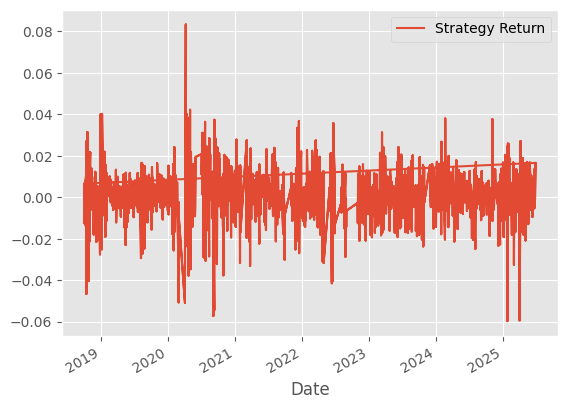

In [64]:
portafolio_df.plot()

#Compare movement of our portfolio vs. movement of SNP500


In [65]:
first_date = pd.to_datetime(sorted(fixed_dates.keys())[0])

In [66]:
type(first_date.date())

datetime.date

In [84]:
spy_data = yf.download(tickers='SPY', start = first_date, end = dt.date.today())

spy_ret = np.log(spy_data['Close'] / spy_data['Close'].shift(1)).dropna().rename({'Close': 'SPYReturns'}, axis = 1)
spy_ret

ERROR:yfinance:Failed to get ticker 'SPY' reason: unexpected character: line 1 column 1 (char 0)
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SPY']: YFTzMissingError('possibly delisted; no timezone found')


Ticker,SPY
Date,


In [72]:
portafolio_df = portafolio_df.merge(spy_ret, left_index = True, right_index = True)

In [80]:
portafolio_df

,Strategy Return,SPY Returns
Date,,
2018-10-02,-0.012852,-0.000583
2018-10-03,-0.002477,0.000549
2018-10-04,-0.010727,-0.007846
2018-10-05,-0.003657,-0.005613
2018-10-08,-0.014011,0.000000
...,...,...
2025-06-24,0.013022,0.010987
2025-06-25,-0.005182,0.000560
2025-06-26,0.011749,0.007793


In [94]:
portafolio_df = portafolio_df.drop_duplicates()

##compared cumulative return

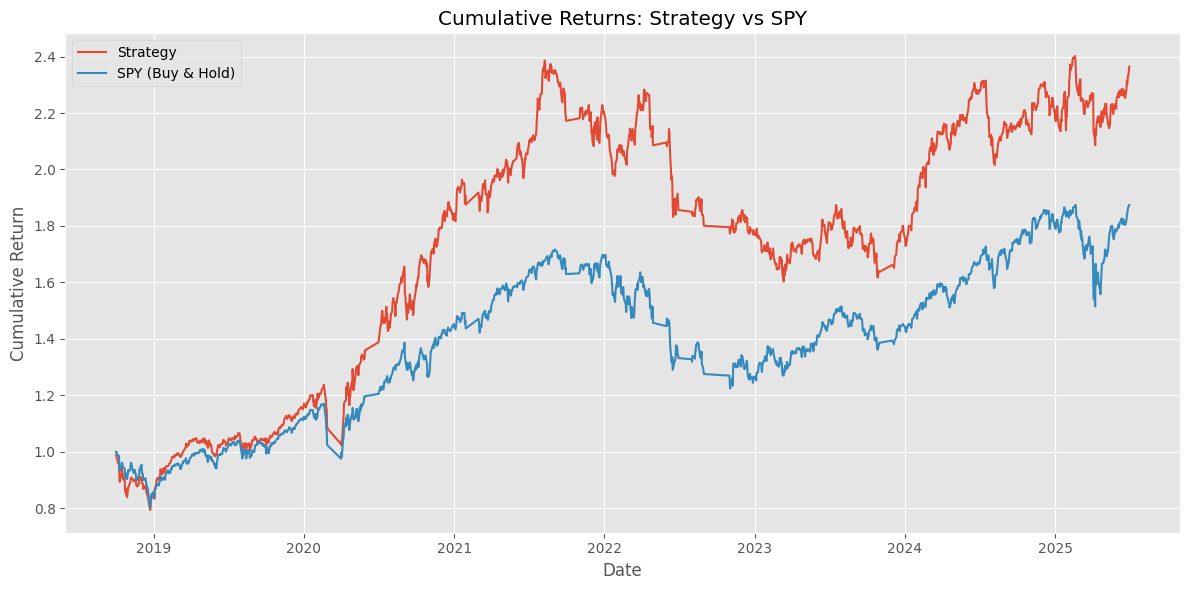

In [96]:
plt.style.use('ggplot')


# Calculate cumulative returns
cumulative_returns = (1 + portafolio_df[['Strategy Return', 'SPY Returns']]).cumprod()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label=['Strategy', 'SPY (Buy & Hold)'])
plt.title('Cumulative Returns: Strategy vs SPY')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()